* Cory Clayton (acc2ds@virginia.edu)
- DS5001
- 6 May 2021


# Web scraper and Token table creator for movie scripts

## set up

In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy
import re
import requests
import itertools

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Cory\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
movie_dataframe=pd.DataFrame()

## Raw Script Text

In [5]:
movie_content=requests.get("https://transcripts.fandom.com/wiki/Rogue_One:_A_Star_Wars_Story")
movie = BeautifulSoup(movie_content.text,"html")
script_lines=[line.text for line in movie.find_all('p')]
#script_lines=[line.split('\n') for line in script_lines]
script_lines

['A long time ago in a galaxy far, far away....\n',
 'Opens on a shot of a planet which pans up to a view of planetary rings with a small ship flying through them. Switches to a shot of the planet Lah’mu and the ship flying through the rings. A shot of the planet closer up with the ship flying towards the surface. The ship flies down across a farm and passes by a white worker droid, who watches the ship. Cuts to a young Jyn Erso running across the rocky plain with the ship following behind her.\n',
 'INT. ERSO HOMESTEAD (Inside the Erso homestead)\n',
 'YOUNG JYN ERSO: Mama.\n',
 'LYRA ERSO: We know. Jyn, gather your things, it’s time.\n',
 'The ship lands near the Erso homestead. Lyra contacts Saw Gerrera.\n',
 'SAW GERRERA: Hello.\n',
 'LYRA ERSO: Saw, it’s Lyra. It’s happened. He’s come for us.\n',
 'SAW GERRERA: You know what to do.\n',
 'GALEN ERSO: Jyn, come here. Remember, whatever I do, I do it to protect you. Say you understand.\n',
 'Galen embraces Jyn and the two stand still

## Function to get a token table from a script

In [6]:
# function takes a link to the webpage, the type of html tag used for dialogue and start and stop lines
def get_token_table(link,tag,start=None,end=None):
  movie_content=requests.get(link)
  movie = BeautifulSoup(movie_content.text,"html")
  script_lines=[line.text for line in movie.find_all(tag)]
  script_lines=[line.split('\n') for line in script_lines]
  script_lines=script_lines[start: end]
  script_flatten_lines = list(itertools.chain(*script_lines))
  script_df=pd.DataFrame(script_flatten_lines,columns=['line_str'])
  script_df['dialogue']=script_df.line_str.str.match("^[\(A-Z][\w\-A-Za-z\W\)]+([\s][A-Za-z]+)*:")
  script_df=script_df.query("line_str!=''")
  script_df['character']=[re.split(":",text)[0] if diag==True else "Action" for text,diag in zip(script_df['line_str'],script_df['dialogue'])]
  script_df['line']=["".join(re.split(":",text)[1:]) if diag==True else "Action" for text,diag in zip(script_df['line_str'],script_df['dialogue'])]

  script_df['line']=[ re.sub("\([\s\w.\',\-\"]+\)","",text) for text in script_df['line']]
  script_df['line']=[ re.sub("\[[\s\w.\',\-\"]+\]","",text) for text in script_df['line']]

  script_df['action']=script_df.line_str.str.match("\[([\W\w]+)\]")
  script_df['continuity']=(script_df.character!=script_df.character.shift()).cumsum()
  script_df['line']=[re.sub("(\[)|(\])","",line)if text=="Action" else text for text,line in zip(script_df['line'],script_df['line_str'])]
  script_df=script_df.groupby(['character','continuity'])['line'].apply(lambda x: " ".join(x)).to_frame().reset_index().sort_values("continuity")
  action_num=[i+1 for i in range(script_df.loc[script_df["character"]=="Action"].shape[0])]
  script_df.loc[script_df["character"]=="Action","action_number"]=action_num
  script_df['action_number']=script_df['action_number'].ffill()
  script_df['action_number']=script_df['action_number'].fillna(0)
  #action_lines=[text for character, text in zip(script_df['character'],script_df["line"]) if character == "Action"] 
  #script_df.loc[script_df.character=="Action","Action"]=action_lines
  #script_df['Action']=script_df['Action'].ffill()
  script_df=script_df.loc[~script_df.character.str.match("Action")]
  script_df['Dialogue_num']=[i+1 for i in range(len(script_df['continuity']))]
  character_map=script_df[['character','Dialogue_num']].set_index("Dialogue_num")
  script_df=script_df.set_index(["action_number","Dialogue_num"])
  script_df=script_df['line'].str.split(r"[.?!;:]+",expand=True).stack().to_frame().rename(columns={0:'sent_str'})
  script_df=script_df.loc[~script_df.sent_str.str.match(r"\n")]
  script_df.index.names = ['Action_number','Dialogue_num',"sent_num"]
  script_df=script_df['sent_str'].apply(lambda x: pd.Series(nltk.pos_tag(nltk.WhitespaceTokenizer().tokenize(x)))).stack().to_frame().rename(columns={0:'pos_tuple'})
  script_df['pos'] = script_df.pos_tuple.apply(lambda x: x[1])
  script_df['token_str'] = script_df.pos_tuple.apply(lambda x: x[0])
  script_df=script_df.loc[(script_df.token_str!="")]
  script_df.index.names = ['Action_number','Dialogue_num',"sent_num","token_num"]
  script_df['term_str']=script_df.token_str.replace(r"\W+","",regex=True).str.lower()
  return script_df,character_map
  


## Scrape movies

### Rogue One

In [7]:
rogue_one,rogue_map=get_token_table("https://transcripts.fandom.com/wiki/Rogue_One:_A_Star_Wars_Story","p")
rogue_one

pos_tuple  pos token_str  \
Action_number Dialogue_num sent_num token_num                                 
1.0           1            0        0             (Mama, NN)   NN      Mama   
              2            0        0              (We, PRP)  PRP        We   
                                    1            (know, VBP)  VBP      know   
                           1        0            (Jyn,, NNP)  NNP      Jyn,   
                                    1           (gather, CC)   CC    gather   
...                                                      ...  ...       ...   
254.0         858          4        2              (it, PRP)  PRP        it   
                                    3          (they’ve, JJ)   JJ   they’ve   
                                    4            (sent, VBD)  VBD      sent   
                                    5              (us, PRP)  PRP        us   
255.0         859          0        0             (Hope, NN)   NN      Hope   

                                              term_str  
Action_number Dialogue_num sent_num token_num           
1.0           1            0        0             mama  
              2            0        0               we  
                                    1             know  
                           1        0              jyn  
                                    1           gather  
...                                                ...  
254.0         858          4        2               it  
                                    3           theyve  
                                    4             sent  
                                    5               us  
255.0         859          0        0             hope  

[8136 rows x 4 columns]

In [8]:
rogue_map

,character
Dialogue_num,
1,YOUNG JYN ERSO
2,LYRA ERSO
3,SAW GERRERA
4,LYRA ERSO
5,SAW GERRERA
...,...
855,REBEL
856,REBEL
857,REBEL


In [9]:
rogue_map.character.unique()

array(['YOUNG JYN ERSO', 'LYRA ERSO', 'SAW GERRERA', 'GALEN ERSO',
       'DIRECTOR ORSON KRENNIC', 'DEATHTROOPER', 'ROGUE ONE',
       'STORMTROOPER', 'RING OF KAFRENE', 'TIVIK', 'CASSIAN ANDOR',
       'STORMTROOPER 1', 'STORMTROOPER 2', 'STORMTROOPER 3', 'JEDHA',
       'MILITIA', 'BODHI ROOK', 'EDRIO TWO TUBES', 'WOBANI', 'SOLDIER',
       'SERGEANT RUESCOTT MELSHI', 'PRISONER', 'K-2SO [KAY-TUESSO]',
       'YAVIN 4', 'PA', 'GENERAL DAVITS DRAVEN', 'JYN ERSO',
       'SENATOR MON MOTHMA', 'GRAND MOFF WILHUFF TARKIN',
       'K-2SO [KAY-TUESSO], coming out of the U-Wing',
       'DR. CORNELIUS EVAZAN', 'CHIRRUT ÎMWE', 'MOTHER', 'PARTISAN',
       'BAZE MALBUS', 'BAZE ÎMWE', 'KRENNIC', 'CAPTAIN DUNSTIG PTERRO',
       'GUNNER', 'CASSIAN', 'REBEL', 'EADU', 'ENGINEER 1', 'ENGINEER 2',
       'ENGINEER', 'REBEL PILOT', 'VANEE', 'DARTH VADER',
       'SENATOR TYNNRA PAMLO', 'BAIL ORGANA', 'ADMIRAL RADDUS',
       'SENATOR VASP VASPAR', 'SENATOR NOWER JEBEL', 'ANTOC MERRICK',
       'GENE

In [10]:
rogue_one=rogue_one.reset_index()
min_dict=rogue_one.groupby(['Action_number'])['Dialogue_num'].min().to_dict()
rogue_one['Dialogue_num']=[diag_num-min_dict[act_num] for act_num,diag_num in zip(rogue_one['Action_number'],rogue_one['Dialogue_num'])]

In [11]:
rogue_one["movie_id"]='m1'
rogue_one=rogue_one.set_index(["movie_id","Action_number","Dialogue_num","sent_num"])
movie_dataframe=movie_dataframe.append(rogue_one)

In [12]:
movie_dataframe

token_num      pos_tuple  pos  \
movie_id Action_number Dialogue_num sent_num                                  
m1       1.0           0            0                 0     (Mama, NN)   NN   
                       1            0                 0      (We, PRP)  PRP   
                                    0                 1    (know, VBP)  VBP   
                                    1                 0    (Jyn,, NNP)  NNP   
                                    1                 1   (gather, CC)   CC   
...                                                 ...            ...  ...   
         254.0         0            4                 2      (it, PRP)  PRP   
                                    4                 3  (they’ve, JJ)   JJ   
                                    4                 4    (sent, VBD)  VBD   
                                    4                 5      (us, PRP)  PRP   
         255.0         0            0                 0     (Hope, NN)   NN   

                                             token_str term_str  
movie_id Action_number Dialogue_num sent_num                     
m1       1.0           0            0             Mama     mama  
                       1            0               We       we  
                                    0             know     know  
                                    1             Jyn,      jyn  
                                    1           gather   gather  
...                                                ...      ...  
         254.0         0            4               it       it  
                                    4          they’ve   theyve  
                                    4             sent     sent  
                                    4               us       us  
         255.0         0            0             Hope     hope  

[8136 rows x 5 columns]

### Revenge of the Sith


In [13]:
sith,sith_map=get_token_table("https://transcripts.fandom.com/wiki/Star_Wars_Episode_III:_Revenge_of_the_Sith","p")
sith

pos_tuple  pos token_str  \
Action_number Dialogue_num sent_num token_num                                
1.0           1            0        0           (There, EX)   EX     There   
                                    1          (isn't, VBZ)  VBZ     isn't   
                                    2               (a, DT)   DT         a   
                                    3           (droid, NN)   NN     droid   
                                    4           (made, VBD)  VBD      made   
...                                                     ...  ...       ...   
384.0         1142         3        4            (mind, NN)   NN      mind   
                                    5          (wiped, VBD)  VBD     wiped   
              1143         0        0            (What, WP)   WP      What   
                           1        0            (Oh,, NNP)  NNP       Oh,   
                                    1              (no, DT)   DT        no   

                                              term_str  
Action_number Dialogue_num sent_num token_num           
1.0           1            0        0            there  
                                    1             isnt  
                                    2                a  
                                    3            droid  
                                    4             made  
...                                                ...  
384.0         1142         3        4             mind  
                                    5            wiped  
              1143         0        0             what  
                           1        0               oh  
                                    1               no  

[12125 rows x 4 columns]

In [14]:
sith_map.character.unique()

array(['ANAKIN', 'OBI-WAN', 'ODD BALL', 'CLONE PILOT 2',
       'GENERAL GRIEVOUS', 'CAPTAIN', 'BODYGUARD I',
       'SUPER BATTLE DROID R77', 'BATTLE DROID', 'SUPER BATTLE DROID 1',
       'SUPER BATTLE DROID 2', 'DROID 1', 'DROID 2', 'PALPATINE',
       'COUNT DOOKU', 'PILOT', 'ANAKINN', 'ANAKIN/OBI-WAN', 'BODYGUARD',
       'SUPER BATTLE DROID', 'FlRESHIP PILOT', 'MACE WlNDU',
       'BAIL ORGANA', 'C-3PO', 'PADME', 'SUPER BATTLE DROID G21',
       'DARTH SlDIOUS', 'YODA', 'FANG ZAR', 'MON MOTHMA', 'GIDDEAN DANU',
       'TERR TANEEL', 'GlDDEAN DANU', 'MACE', 'Kl-ADI-MUNDI',
       'OBI-WAN\xa0', 'CAPTAIN TYPHO', 'MOTEE', 'CLONE COMMANDER GREE',
       'BANA BREEMU', 'GiDDEAN DANU', 'CHI EEKWAY',
       'CLONE COMMANDER CODY', 'JAR JAR', 'TlON MEDON',
       "OBI-WAN starts back toward his Starfighter as TION MEDON leaves the Landing Platform. GRIEVOUS's BODYGUARDS retreat from the overhead platform. OBI-WAN climbs back into his BLUE JEDI FIGHTER. His Astro Unit (R4-G9) turns to him

In [15]:
sith_map_nums=sith_map.query("character=='PALPATINE listens to a delegation from the Senate, which includes PADME and five other Senators'").reset_index().Dialogue_num.to_list()
sith_map_nums2=sith_map.query("character=='PALPATINE is putting on his dark cloak'").reset_index().Dialogue_num.to_list()

In [16]:
sith=sith.query("Dialogue_num not in @sith_map_nums")
sith=sith.query("Dialogue_num not in @sith_map_nums2")

In [17]:
sith

pos_tuple  pos token_str  \
Action_number Dialogue_num sent_num token_num                                
1.0           1            0        0           (There, EX)   EX     There   
                                    1          (isn't, VBZ)  VBZ     isn't   
                                    2               (a, DT)   DT         a   
                                    3           (droid, NN)   NN     droid   
                                    4           (made, VBD)  VBD      made   
...                                                     ...  ...       ...   
384.0         1142         3        4            (mind, NN)   NN      mind   
                                    5          (wiped, VBD)  VBD     wiped   
              1143         0        0            (What, WP)   WP      What   
                           1        0            (Oh,, NNP)  NNP       Oh,   
                                    1              (no, DT)   DT        no   

                                              term_str  
Action_number Dialogue_num sent_num token_num           
1.0           1            0        0            there  
                                    1             isnt  
                                    2                a  
                                    3            droid  
                                    4             made  
...                                                ...  
384.0         1142         3        4             mind  
                                    5            wiped  
              1143         0        0             what  
                           1        0               oh  
                                    1               no  

[12102 rows x 4 columns]

In [18]:
sith=sith.reset_index()
min_dict=sith.groupby(['Action_number'])['Dialogue_num'].min().to_dict()
sith['Dialogue_num']=[diag_num-min_dict[act_num] for act_num,diag_num in zip(sith['Action_number'],sith['Dialogue_num'])]

In [19]:
sith["movie_id"]='m2'
sith=sith.set_index(["movie_id","Action_number","Dialogue_num","sent_num"])
movie_dataframe=movie_dataframe.append(sith)

In [20]:
movie_dataframe

token_num     pos_tuple  pos  \
movie_id Action_number Dialogue_num sent_num                                 
m1       1.0           0            0                 0    (Mama, NN)   NN   
                       1            0                 0     (We, PRP)  PRP   
                                    0                 1   (know, VBP)  VBP   
                                    1                 0   (Jyn,, NNP)  NNP   
                                    1                 1  (gather, CC)   CC   
...                                                 ...           ...  ...   
m2       384.0         2            3                 4    (mind, NN)   NN   
                                    3                 5  (wiped, VBD)  VBD   
                       3            0                 0    (What, WP)   WP   
                                    1                 0    (Oh,, NNP)  NNP   
                                    1                 1      (no, DT)   DT   

                                             token_str term_str  
movie_id Action_number Dialogue_num sent_num                     
m1       1.0           0            0             Mama     mama  
                       1            0               We       we  
                                    0             know     know  
                                    1             Jyn,      jyn  
                                    1           gather   gather  
...                                                ...      ...  
m2       384.0         2            3             mind     mind  
                                    3            wiped    wiped  
                       3            0             What     what  
                                    1              Oh,       oh  
                                    1               no       no  

[20238 rows x 5 columns]

### Rise of Skywalker

In [21]:
ros,ros_map=get_token_table("https://transcripts.fandom.com/wiki/Star_Wars_Episode_IX:_The_Rise_of_Skywalker","p",start=14,end=-1)
ros

pos_tuple  pos  \
Action_number Dialogue_num sent_num token_num                          
1.0           1            0        0                  (At, IN)   IN   
                                    1                (last, JJ)   JJ   
2.0           2            0        0               (Snoke, NN)   NN   
                           1        0            (trained, VBN)  VBN   
                                    1                (you, PRP)  PRP   
...                                                         ...  ...   
317.0         1027         0        1                (Rey, NNP)  NNP   
              1028         0        0                (Rey, NNP)  NNP   
                                    1                 (who, WP)   WP   
318.0         1029         0        0                (Rey, NNP)  NNP   
                                    1          (Skywalker, NNP)  NNP   

                                               token_str   term_str  
Action_number Dialogue_num sent_num token_num                        
1.0           1            0        0                 At         at  
                                    1               last       last  
2.0           2            0        0              Snoke      snoke  
                           1        0            trained    trained  
                                    1                you        you  
...                                                  ...        ...  
317.0         1027         0        1                Rey        rey  
              1028         0        0                Rey        rey  
                                    1                who        who  
318.0         1029         0        0                Rey        rey  
                                    1          Skywalker  skywalker  

[7387 rows x 4 columns]

In [22]:
ros_map.reset_index().character.unique()

array(['PALPATINE', 'KYLO REN', 'POE', 'FINN', 'BOOLIO', 'TIE PILOT',
       'REY', 'LEIA', 'YOUNG REY', 'DARTH VADER', 'LUKE', 'HAN',
       'KAYDEL KO CONNIX', 'NIMI CHIREEN', 'MAN', 'MAN 2', 'WOMAN',
       'Poe Dameron', 'Rey', 'Finn', 'ROSE', 'AFTAB', 'BEAUMONT', 'C-3PO',
       'MAZ', 'STORMTROOPER 1', 'STORMTROOPER 2', 'ARMITAGE HUX',
       'BELLAVA PARNADEE', 'DOMARIC QUINN', 'ENRIC PRYDE', 'AMRET ENGELL',
       'TISHRA KANDIA', 'STORMTROOPER', "KALO'NE", 'LANDO', 'SNAP', 'D-O',
       'ANNOUNCER', 'STORMTROOPER 3', 'STORMTROOPER 4', 'STORMTROOPER 5',
       'ZORII', 'BABU', 'FRANTIS GRISS', 'FEMALE STORMTROOPER',
       'FEMALE STORMTROOPER 2', 'FEMALE STORMTROOPER 3', "REY'S MOTHER",
       "REY'S FATHER", 'FIRST ORDER OFFICER', 'JANNAH', 'SITH REY',
       "LARMA D'ACY", 'LARMA', 'SIMERO QUONIT', 'MILON LENWITH',
       'CHESILLE SABROND', 'WROBIE TYCE', 'VANIK', 'NIEN NUNB',
       'FEMALE SITH OFFICER', 'FEMALE FLEET TECHNICIAN', 'SITH TROOPER',
       'ENICE PRYCE', 'MA

In [23]:
ros=ros.reset_index()
min_dict=ros.groupby(['Action_number'])['Dialogue_num'].min().to_dict()
ros['Dialogue_num']=[diag_num-min_dict[act_num] for act_num,diag_num in zip(ros['Action_number'],ros['Dialogue_num'])]

In [24]:
ros["movie_id"]='m3'
ros=ros.set_index(["movie_id","Action_number","Dialogue_num","sent_num"])
movie_dataframe=movie_dataframe.append(ros)

In [25]:
movie_dataframe

token_num         pos_tuple  \
movie_id Action_number Dialogue_num sent_num                                
m1       1.0           0            0                 0        (Mama, NN)   
                       1            0                 0         (We, PRP)   
                                    0                 1       (know, VBP)   
                                    1                 0       (Jyn,, NNP)   
                                    1                 1      (gather, CC)   
...                                                 ...               ...   
m3       317.0         1            0                 1        (Rey, NNP)   
                       2            0                 0        (Rey, NNP)   
                                    0                 1         (who, WP)   
         318.0         0            0                 0        (Rey, NNP)   
                                    0                 1  (Skywalker, NNP)   

                                              pos  token_str   term_str  
movie_id Action_number Dialogue_num sent_num                             
m1       1.0           0            0          NN       Mama       mama  
                       1            0         PRP         We         we  
                                    0         VBP       know       know  
                                    1         NNP       Jyn,        jyn  
                                    1          CC     gather     gather  
...                                           ...        ...        ...  
m3       317.0         1            0         NNP        Rey        rey  
                       2            0         NNP        Rey        rey  
                                    0          WP        who        who  
         318.0         0            0         NNP        Rey        rey  
                                    0         NNP  Skywalker  skywalker  

[27625 rows x 5 columns]

### Captain America

In [26]:
ca_tokens,ca_map=get_token_table("https://transcripts.fandom.com/wiki/Captain_America:_The_First_Avenger","dd")
ca_tokens

pos_tuple  pos token_str  \
Action_number Dialogue_num sent_num token_num                                 
1.0           1            0        0             (Are, NNP)  NNP       Are   
                                    1             (you, PRP)  PRP       you   
                                    2              (the, DT)   DT       the   
                                    3            (guys, NNS)  NNS      guys   
                                    4             (from, IN)   IN      from   
...                                                      ...  ...       ...   
107.0         682          0        7            (world, NN)   NN     world   
              683          0        0          (Trying, VBG)  VBG    Trying   
                                    1               (to, TO)   TO        to   
                                    2             (save, VB)   VB      save   
                                    3              (it, PRP)  PRP        it   

                                              term_str  
Action_number Dialogue_num sent_num token_num           
1.0           1            0        0              are  
                                    1              you  
                                    2              the  
                                    3             guys  
                                    4             from  
...                                                ...  
107.0         682          0        7            world  
              683          0        0           trying  
                                    1               to  
                                    2             save  
                                    3               it  

[7779 rows x 4 columns]

In [27]:
ca_map.reset_index().character.unique()

array(['Search Team Leader', 'SHIELD Tech', 'SHIELD Lieutenant',
       'Voice from Earpiece', 'Jan', 'Tower Keeper', 'Hydra Lieutenant',
       'Johann Schmidt', 'Steve Rogers', 'Enlistment Guy',
       'Commercial Announcer', 'Loud Jerk', 'Steve Roger', 'James Barnes',
       'Connie', 'Expo Announcer', 'Mandy', 'Random Woman',
       'Howard Stark', 'Woman', 'Young Doctor', 'Dr. Abraham Erskine',
       'Dr. Arnim Zola', 'Officer', 'Peggy Carter', 'Gilmore Hodge',
       'Col. Chester Phillips', 'Sergeant Duffy', 'Soldiers',
       'Antique Store Owner', 'Senator Brandt', 'Heinz Kruger',
       'SSR Doctor', 'Taxi Driver', 'Mother', 'Young Boy', 'Hutter',
       'Schneider', 'Roeder', 'HYDRA technicians', 'Brandt’s Aide',
       'USO Singer', 'Director', 'Kids in USO Audience', 'Army Heckler#1',
       'Army Heckler#2', 'Army Heckler#3', 'Army Heckler#4', 'USO girl',
       'Dum Dum Dugan', 'HYDRA guards', 'Gabe Jones',
       'James Montgomery Falsworth', 'Jim Morita', 'Corporal', 

In [28]:
ca_tokens=ca_tokens.reset_index()
min_dict=ca_tokens.groupby(['Action_number'])['Dialogue_num'].min().to_dict()
ca_tokens['Dialogue_num']=[diag_num-min_dict[act_num] for act_num,diag_num in zip(ca_tokens['Action_number'],ca_tokens['Dialogue_num'])]

In [29]:
ca_tokens["movie_id"]='m4'
ca_tokens=ca_tokens.set_index(["movie_id","Action_number","Dialogue_num","sent_num"])
movie_dataframe=movie_dataframe.append(ca_tokens)

In [30]:
movie_dataframe

token_num      pos_tuple  pos  \
movie_id Action_number Dialogue_num sent_num                                  
m1       1.0           0            0                 0     (Mama, NN)   NN   
                       1            0                 0      (We, PRP)  PRP   
                                    0                 1    (know, VBP)  VBP   
                                    1                 0    (Jyn,, NNP)  NNP   
                                    1                 1   (gather, CC)   CC   
...                                                 ...            ...  ...   
m4       107.0         3            0                 7    (world, NN)   NN   
                       4            0                 0  (Trying, VBG)  VBG   
                                    0                 1       (to, TO)   TO   
                                    0                 2     (save, VB)   VB   
                                    0                 3      (it, PRP)  PRP   

                                             token_str term_str  
movie_id Action_number Dialogue_num sent_num                     
m1       1.0           0            0             Mama     mama  
                       1            0               We       we  
                                    0             know     know  
                                    1             Jyn,      jyn  
                                    1           gather   gather  
...                                                ...      ...  
m4       107.0         3            0            world    world  
                       4            0           Trying   trying  
                                    0               to       to  
                                    0             save     save  
                                    0               it       it  

[35404 rows x 5 columns]

### Captain America: Winter Soldier

In [31]:
ca_winter_soldier,wint_map=get_token_table("https://transcripts.fandom.com/wiki/Captain_America:_The_Winter_Soldier",['p','dd'])

In [32]:
ca_winter_soldier

pos_tuple   pos  \
Action_number Dialogue_num sent_num token_num                          
1.0           1            0        0                 (On, IN)    IN   
                                    1             (your, PRP$)  PRP$   
                                    2               (left, NN)    NN   
2.0           2            0        0                 (On, IN)    IN   
                                    1             (your, PRP$)  PRP$   
...                                                        ...   ...   
124.0         837          4        6            (miracle, NN)    NN   
125.0         838          0        0                (The, DT)    DT   
                                    1            (Winter, NNP)   NNP   
                                    2          (Soldier", NNP)   NNP   
                           1        0                   (), ))     )   

                                              token_str term_str  
Action_number Dialogue_num sent_num token_num                     
1.0           1            0        0                On       on  
                                    1              your     your  
                                    2              left     left  
2.0           2            0        0                On       on  
                                    1              your     your  
...                                                 ...      ...  
124.0         837          4        6           miracle  miracle  
125.0         838          0        0               The      the  
                                    1            Winter   winter  
                                    2          Soldier"  soldier  
                           1        0                 )           

[9340 rows x 4 columns]

In [33]:
wint_map.character.unique()

array(['Steve Rogers', 'Sam Wilson', '(Steve gets a text message',
       'Natasha Romanoff', 'Brock Rumlow', 'Pilot', 'STRIKE Agent',
       'French Pirate #1', 'Georges Batroc', 'French Pirate', 'Durand',
       'French Pirate #2', 'Jasper Sitwell', 'Nick Fury',
       'SHIELD Computer', 'The Smithsonian Narrator', 'Woman on PA',
       'Old Footage Recording', 'Peggy Carter', 'Councilman Rockwell',
       'Councilman Singh', 'Councilwoman Hawley', 'Councilman Yen',
       'Alexander Pierce', 'Female War Veteran', "Fury's Car",
       'Maria Hill', 'Sharon Carter', 'SHIELD Agent', 'Male Nurse',
       'Female Nurse', 'Doctor', 'Doctor #1', 'STRIKE Agent #1',
       'STRIKE Agent #2', 'SHIELD Agent #1', 'SHIELD Agent #2',
       'STRIKE Agent #3', 'Quinjet Pilot', 'Apple Employee',
       'Jack Rollins', 'SHIELD Agent #3', 'Sergeant Duffy', 'Computer',
       'Dr. Arnim Zola', 'Renata', 'Senator Stern', 'Winter Soldier',
       'Bucky Barnes', 'Scientist #1', 'Smithsonian Guard', 'Man

In [34]:
wint_exclude_nums=wint_map.query("character=='(Steve gets a text message'").reset_index().Dialogue_num.to_list()

In [35]:
ca_winter_soldier=ca_winter_soldier.query("Dialogue_num not in @wint_exclude_nums")

In [36]:
ca_winter_soldier

pos_tuple   pos  \
Action_number Dialogue_num sent_num token_num                          
1.0           1            0        0                 (On, IN)    IN   
                                    1             (your, PRP$)  PRP$   
                                    2               (left, NN)    NN   
2.0           2            0        0                 (On, IN)    IN   
                                    1             (your, PRP$)  PRP$   
...                                                        ...   ...   
124.0         837          4        6            (miracle, NN)    NN   
125.0         838          0        0                (The, DT)    DT   
                                    1            (Winter, NNP)   NNP   
                                    2          (Soldier", NNP)   NNP   
                           1        0                   (), ))     )   

                                              token_str term_str  
Action_number Dialogue_num sent_num token_num                     
1.0           1            0        0                On       on  
                                    1              your     your  
                                    2              left     left  
2.0           2            0        0                On       on  
                                    1              your     your  
...                                                 ...      ...  
124.0         837          4        6           miracle  miracle  
125.0         838          0        0               The      the  
                                    1            Winter   winter  
                                    2          Soldier"  soldier  
                           1        0                 )           

[9331 rows x 4 columns]

In [37]:
ca_winter_soldier=ca_winter_soldier[0:9327]
ca_winter_soldier

pos_tuple   pos  \
Action_number Dialogue_num sent_num token_num                           
1.0           1            0        0                  (On, IN)    IN   
                                    1              (your, PRP$)  PRP$   
                                    2                (left, NN)    NN   
2.0           2            0        0                  (On, IN)    IN   
                                    1              (your, PRP$)  PRP$   
...                                                         ...   ...   
124.0         837          4        2               (more, RBR)   RBR   
                                    3          (horrifying, NN)    NN   
                                    4                (than, IN)    IN   
                                    5                   (a, DT)    DT   
                                    6             (miracle, NN)    NN   

                                                token_str    term_str  
Action_number Dialogue_num sent_num token_num                          
1.0           1            0        0                  On          on  
                                    1                your        your  
                                    2                left        left  
2.0           2            0        0                  On          on  
                                    1                your        your  
...                                                   ...         ...  
124.0         837          4        2                more        more  
                                    3          horrifying  horrifying  
                                    4                than        than  
                                    5                   a           a  
                                    6             miracle     miracle  

[9327 rows x 4 columns]

In [38]:
ca_winter_soldier=ca_winter_soldier.reset_index()
min_dict=ca_winter_soldier.groupby(['Action_number'])['Dialogue_num'].min().to_dict()
ca_winter_soldier['Dialogue_num']=[diag_num-min_dict[act_num] for act_num,diag_num in zip(ca_winter_soldier['Action_number'],ca_winter_soldier['Dialogue_num'])]

In [39]:
ca_winter_soldier["movie_id"]='m5'
ca_winter_soldier=ca_winter_soldier.set_index(["movie_id","Action_number","Dialogue_num","sent_num"])
movie_dataframe=movie_dataframe.append(ca_winter_soldier)

In [40]:
movie_dataframe

token_num         pos_tuple  \
movie_id Action_number Dialogue_num sent_num                                
m1       1.0           0            0                 0        (Mama, NN)   
                       1            0                 0         (We, PRP)   
                                    0                 1       (know, VBP)   
                                    1                 0       (Jyn,, NNP)   
                                    1                 1      (gather, CC)   
...                                                 ...               ...   
m5       124.0         7            4                 2       (more, RBR)   
                                    4                 3  (horrifying, NN)   
                                    4                 4        (than, IN)   
                                    4                 5           (a, DT)   
                                    4                 6     (miracle, NN)   

                                              pos   token_str    term_str  
movie_id Action_number Dialogue_num sent_num                               
m1       1.0           0            0          NN        Mama        mama  
                       1            0         PRP          We          we  
                                    0         VBP        know        know  
                                    1         NNP        Jyn,         jyn  
                                    1          CC      gather      gather  
...                                           ...         ...         ...  
m5       124.0         7            4         RBR        more        more  
                                    4          NN  horrifying  horrifying  
                                    4          IN        than        than  
                                    4          DT           a           a  
                                    4          NN     miracle     miracle  

[44731 rows x 5 columns]

### Captain America: Civil War

In [41]:
civil_war,cw_map=get_token_table("https://transcripts.fandom.com/wiki/Captain_America:_Civil_War","dd")

In [42]:
civil_war

pos_tuple  pos  \
Action_number Dialogue_num sent_num token_num                          
1.0           1            0        0             (Желание, NN)   NN   
                           1        0              (Ржавый, NN)   NN   
                           2        0          (Семнадцать, NN)   NN   
                           3        0             (Рассвет, NN)   NN   
                           4        0                (Печь, NN)   NN   
...                                                         ...  ...   
198.0         986          1        1                 (can, MD)   MD   
                                    2                (you, PRP)  PRP   
                                    3                (shut, VB)   VB   
                                    4                 (the, DT)   DT   
                                    5                (door, NN)   NN   

                                                token_str    term_str  
Action_number Dialogue_num sent_num token_num                          
1.0           1            0        0             Желание     желание  
                           1        0              Ржавый      ржавый  
                           2        0          Семнадцать  семнадцать  
                           3        0             Рассвет     рассвет  
                           4        0                Печь        печь  
...                                                   ...         ...  
198.0         986          1        1                 can         can  
                                    2                 you         you  
                                    3                shut        shut  
                                    4                 the         the  
                                    5                door        door  

[10421 rows x 4 columns]

In [43]:
cw_map.character.unique()

array(['Vasily Karpov', 'Bucky Barnes', 'Steve Rogers', 'Wanda Maximoff',
       'Natasha Romanoff', 'Sam Wilson', 'Brock Rumlow', 'Mercenary',
       'Mercenary #1', 'Mercenary #2', 'Maria Stark', 'Howard Stark',
       'Young Tony Stark', 'Tony Stark', 'MIT teacher',
       "Stark's Assistant", 'Mrs. Spencer', 'Mrs Spencer',
       'News Anchor #1', "King T'Chaka", 'News anchor #2', 'Vision',
       'Secretary Ross', 'James Rhodes', 'Helmut Zemo', 'Priest',
       'Sharon Carter', 'News Anchor #3', 'UN staffer', "T'Challa",
       'Man on speakers', 'News anchor #4', 'German Innkeeper',
       'GSG-9 Soldier', 'GSG-9 Driver', 'Everett Ross',
       'Delivery Truck Driver', 'Custodian', 'Man on PA #1',
       "Zemo's Wife", 'News anchor #5', 'Josef / Super Soldier #1',
       'Peter Parker', 'May Parker', 'Clint Barton', 'Attache',
       'Security Chief', 'Scott Lang', 'Man on PA #2', 'FRIDAY',
       'Inside is a vast, gloomy space cramped with shelves stacked with filing boxes. Zem

In [44]:
cw_remove=cw_map[cw_map.character.str.contains("Inside is a vast")].reset_index().Dialogue_num.to_list()

In [45]:
civil_war=civil_war.query("Dialogue_num not in @cw_remove")

In [46]:
civil_war=civil_war.reset_index()
min_dict=civil_war.groupby(['Action_number'])['Dialogue_num'].min().to_dict()
civil_war['Dialogue_num']=[diag_num-min_dict[act_num] for act_num,diag_num in zip(civil_war['Action_number'],civil_war['Dialogue_num'])]

In [47]:
civil_war["movie_id"]='m6'
civil_war=civil_war.set_index(["movie_id","Action_number","Dialogue_num","sent_num"])
movie_dataframe=movie_dataframe.append(civil_war)

In [48]:
movie_dataframe

token_num     pos_tuple  pos  \
movie_id Action_number Dialogue_num sent_num                                 
m1       1.0           0            0                 0    (Mama, NN)   NN   
                       1            0                 0     (We, PRP)  PRP   
                                    0                 1   (know, VBP)  VBP   
                                    1                 0   (Jyn,, NNP)  NNP   
                                    1                 1  (gather, CC)   CC   
...                                                 ...           ...  ...   
m6       198.0         9            1                 1     (can, MD)   MD   
                                    1                 2    (you, PRP)  PRP   
                                    1                 3    (shut, VB)   VB   
                                    1                 4     (the, DT)   DT   
                                    1                 5    (door, NN)   NN   

                                             token_str term_str  
movie_id Action_number Dialogue_num sent_num                     
m1       1.0           0            0             Mama     mama  
                       1            0               We       we  
                                    0             know     know  
                                    1             Jyn,      jyn  
                                    1           gather   gather  
...                                                ...      ...  
m6       198.0         9            1              can      can  
                                    1              you      you  
                                    1             shut     shut  
                                    1              the      the  
                                    1             door     door  

[55150 rows x 5 columns]

### The Avengers

In [49]:
av_tokens,av_map=get_token_table("https://transcripts.fandom.com/wiki/The_Avengers","p",start=4)
av_tokens

pos_tuple  pos  \
Action_number Dialogue_num sent_num token_num                         
0.0           1            0        0                (The, DT)   DT   
                                    1          (tesseract, NN)   NN   
                                    2               (has, VBZ)  VBZ   
                                    3          (awakened, VBN)  VBN   
                           1        0                (It, PRP)  PRP   
...                                                        ...  ...   
249.0         928          4        2              (them, PRP)  PRP   
                                    3                (is, VBZ)  VBZ   
                                    4                 (to, TO)   TO   
                                    5              (court, NN)   NN   
                           5        0              (Death, NN)   NN   

                                               token_str   term_str  
Action_number Dialogue_num sent_num token_num                        
0.0           1            0        0                The        the  
                                    1          tesseract  tesseract  
                                    2                has        has  
                                    3           awakened   awakened  
                           1        0                 It         it  
...                                                  ...        ...  
249.0         928          4        2               them       them  
                                    3                 is         is  
                                    4                 to         to  
                                    5              court      court  
                           5        0              Death      death  

[9601 rows x 4 columns]

In [50]:
av_map.character.unique()

array(['THE OTHER', 'Loki', 'NICK FURY', 'AGENT PHIL COULSON', 'COULSON',
       'FURY', 'AGENT MARIA HILL', 'HILL', 'Dr. ERIK SELVIG', 'SELVIG',
       'CLINT BARTON', 'NASA SCIENCETIST', 'CLINT', 'LOKI',
       'GENERAL LUCHKOV', 'NATASHA ROMANOFF', 'LUCHKOV', 'NATASHA',
       'WEASELY THUG', 'ATTENDING WOMAN', 'LITTLE GIRL', 'BRUCE',
       'BANNER', 'COUNCIL MEMBER 1', 'COUNCIL MEMBER 2', 'STEVE',
       'PEGGY CARTER', 'SHIELD SCIENCETIST', 'TONY', 'PEPPER POTTS',
       'PEPPER', 'JARVIS', 'PILOT', 'AGENT JASPER SITWELL', 'SITWELL',
       'ELDER GERMAN MAN', 'CAPTAIN AMERICA', 'IRON MAN',
       'NICK FURY (V.O.)', 'THOR', "TONY (CONT'D) (TO THOR)", 'TONY\xa0',
       'NICK FURY (O.S.)', 'LOKI (V.O.)', 'SHIELD BASE VOICE', 'BARTON',
       'OUTSIDE THE HELICARRIER', 'GALAGA PLAYER', 'TONY (V.O.)',
       'HELMSMAN', 'CAPTAIN AMERICA (V.O.)',
       'AGENT JASPER SITWELL (V.O.)', 'ESCORT 0-6 PILOT (V.O.)',
       'ESCORT 606 PILOT', 'AGENT JASPER SITWELL (O.S.)', 'STEVE (V.O.)',

In [51]:
av_tokens=av_tokens.reset_index()
min_dict=av_tokens.groupby(['Action_number'])['Dialogue_num'].min().to_dict()
av_tokens['Dialogue_num']=[diag_num-min_dict[act_num] for act_num,diag_num in zip(av_tokens['Action_number'],av_tokens['Dialogue_num'])]

In [52]:
av_tokens["movie_id"]='m7'
av_tokens=av_tokens.set_index(["movie_id","Action_number","Dialogue_num","sent_num"])
movie_dataframe=movie_dataframe.append(av_tokens)

In [53]:
movie_dataframe

token_num     pos_tuple  pos  \
movie_id Action_number Dialogue_num sent_num                                 
m1       1.0           0            0                 0    (Mama, NN)   NN   
                       1            0                 0     (We, PRP)  PRP   
                                    0                 1   (know, VBP)  VBP   
                                    1                 0   (Jyn,, NNP)  NNP   
                                    1                 1  (gather, CC)   CC   
...                                                 ...           ...  ...   
m7       249.0         0            4                 2   (them, PRP)  PRP   
                                    4                 3     (is, VBZ)  VBZ   
                                    4                 4      (to, TO)   TO   
                                    4                 5   (court, NN)   NN   
                                    5                 0   (Death, NN)   NN   

                                             token_str term_str  
movie_id Action_number Dialogue_num sent_num                     
m1       1.0           0            0             Mama     mama  
                       1            0               We       we  
                                    0             know     know  
                                    1             Jyn,      jyn  
                                    1           gather   gather  
...                                                ...      ...  
m7       249.0         0            4             them     them  
                                    4               is       is  
                                    4               to       to  
                                    4            court    court  
                                    5            Death    death  

[64751 rows x 5 columns]

### Avengers Age of Ultron

In [54]:
Age_of_Ultron,ultron_map=get_token_table("https://transcripts.fandom.com/wiki/Avengers:_Age_of_Ultron","p",end=-1)
Age_of_Ultron

pos_tuple   pos  \
Action_number Dialogue_num sent_num token_num                            
0.0           1            0        0              (Report, NNP)   NNP   
                                    1                   (to, TO)    TO   
                                    2               (your, PRP$)  PRP$   
                                    3            (stations, NNS)   NNS   
                                    4          (immediately, RB)    RB   
...                                                          ...   ...   
131.0         973          0        0               (Fine,, NNP)   NNP   
                                    1                (I'll, NNP)   NNP   
                                    2                  (do, VBP)   VBP   
                                    3                  (it, PRP)   PRP   
                                    4              (myself, PRP)   PRP   

                                                 token_str     term_str  
Action_number Dialogue_num sent_num token_num                            
0.0           1            0        0               Report       report  
                                    1                   to           to  
                                    2                 your         your  
                                    3             stations     stations  
                                    4          immediately  immediately  
...                                                    ...          ...  
131.0         973          0        0                Fine,         fine  
                                    1                 I'll          ill  
                                    2                   do           do  
                                    3                   it           it  
                                    4               myself       myself  

[10733 rows x 4 columns]

In [55]:
ultron_map.character.unique()

array(['Announcer', 'Tony Stark', 'Steve Rogers', 'JARVIS', 'Thor',
       'Natasha Romanoff', 'Clint Barton', 'Strucker', 'Fortress Soldier',
       'Other Fortress Soldier', 'Dr. List', 'Jarvis', 'Iron Legion',
       'Soldiers', 'Pietro Maximoff', 'AVENGERS', 'Bruce Banner',
       'Maria Hill', 'Dr. Helen Cho', 'Ultron', 'James Rhodes',
       'Sam Wilson', 'Party Guest', 'Stan Lee', 'Wanda Maximoff',
       'Ulysses Klaue', "Klaue's Mercenary", 'Ballet Instructor',
       'Madame B', 'Peggy Carter', 'Heimdall', 'Laura Barton',
       'Lila Barton', 'Nick Fury', 'Erik Selvig', 'World Hub Tech',
       'Vision', 'FRIDAY', 'Soldier', 'Specialist Cameron Klein',
       'Zrinka', 'Thanos'], dtype=object)

In [56]:
ultron_remove=ultron_map.query("character in ['AVENGERS','END OF AVENGERS']").reset_index().Dialogue_num.to_list()

In [57]:
ultron_remove

[68]

In [58]:
Age_of_Ultron=Age_of_Ultron.query("Dialogue_num not in @ultron_remove")

In [59]:
Age_of_Ultron

pos_tuple   pos  \
Action_number Dialogue_num sent_num token_num                            
0.0           1            0        0              (Report, NNP)   NNP   
                                    1                   (to, TO)    TO   
                                    2               (your, PRP$)  PRP$   
                                    3            (stations, NNS)   NNS   
                                    4          (immediately, RB)    RB   
...                                                          ...   ...   
131.0         973          0        0               (Fine,, NNP)   NNP   
                                    1                (I'll, NNP)   NNP   
                                    2                  (do, VBP)   VBP   
                                    3                  (it, PRP)   PRP   
                                    4              (myself, PRP)   PRP   

                                                 token_str     term_str  
Action_number Dialogue_num sent_num token_num                            
0.0           1            0        0               Report       report  
                                    1                   to           to  
                                    2                 your         your  
                                    3             stations     stations  
                                    4          immediately  immediately  
...                                                    ...          ...  
131.0         973          0        0                Fine,         fine  
                                    1                 I'll          ill  
                                    2                   do           do  
                                    3                   it           it  
                                    4               myself       myself  

[10728 rows x 4 columns]

In [60]:
Age_of_Ultron=Age_of_Ultron.reset_index()
min_dict=Age_of_Ultron.groupby(['Action_number'])['Dialogue_num'].min().to_dict()
Age_of_Ultron['Dialogue_num']=[diag_num-min_dict[act_num] for act_num,diag_num in zip(Age_of_Ultron['Action_number'],Age_of_Ultron['Dialogue_num'])]

In [61]:
Age_of_Ultron["movie_id"]='m8'
Age_of_Ultron=Age_of_Ultron.set_index(["movie_id","Action_number","Dialogue_num","sent_num"])
movie_dataframe=movie_dataframe.append(Age_of_Ultron)

In [62]:
movie_dataframe

token_num      pos_tuple  pos  \
movie_id Action_number Dialogue_num sent_num                                  
m1       1.0           0            0                 0     (Mama, NN)   NN   
                       1            0                 0      (We, PRP)  PRP   
                                    0                 1    (know, VBP)  VBP   
                                    1                 0    (Jyn,, NNP)  NNP   
                                    1                 1   (gather, CC)   CC   
...                                                 ...            ...  ...   
m8       131.0         0            0                 0   (Fine,, NNP)  NNP   
                                    0                 1    (I'll, NNP)  NNP   
                                    0                 2      (do, VBP)  VBP   
                                    0                 3      (it, PRP)  PRP   
                                    0                 4  (myself, PRP)  PRP   

                                             token_str term_str  
movie_id Action_number Dialogue_num sent_num                     
m1       1.0           0            0             Mama     mama  
                       1            0               We       we  
                                    0             know     know  
                                    1             Jyn,      jyn  
                                    1           gather   gather  
...                                                ...      ...  
m8       131.0         0            0            Fine,     fine  
                                    0             I'll      ill  
                                    0               do       do  
                                    0               it       it  
                                    0           myself   myself  

[75479 rows x 5 columns]

### Avengers Infinity War

In [63]:
iw_tokens,iw_map=get_token_table("https://transcripts.fandom.com/wiki/Avengers:_Infinity_War","p")
iw_tokens

pos_tuple  pos  \
Action_number Dialogue_num sent_num token_num                         
1.0           1            0        0               (This, DT)   DT   
                                    1                (is, VBZ)  VBZ   
                                    2                (the, DT)   DT   
                                    3          (Asgardian, JJ)   JJ   
                                    4            (refugee, NN)   NN   
...                                                        ...  ...   
277.0         1013         0        0               (Nick, NN)   NN   
278.0         1014         0        0               (Hill, NN)   NN   
279.0         1015         0        0               (Oh,, NNP)  NNP   
                                    1                 (no, DT)   DT   
                           1        0            (Motherf, NN)   NN   

                                               token_str   term_str  
Action_number Dialogue_num sent_num token_num                        
1.0           1            0        0               This       this  
                                    1                 is         is  
                                    2                the        the  
                                    3          Asgardian  asgardian  
                                    4            refugee    refugee  
...                                                  ...        ...  
277.0         1013         0        0               Nick       nick  
278.0         1014         0        0               Hill       hill  
279.0         1015         0        0                Oh,         oh  
                                    1                 no         no  
                           1        0            Motherf    motherf  

[9178 rows x 4 columns]

In [64]:
iw_map.character.unique()

array(['Asgardian PA', 'Ebony Maw', 'Thanos', 'Thor', 'Loki', 'Hulk',
       'Heimdall', 'Proxima Midnight', 'Stephen Strange', 'Wong',
       'Bruce Banner *out of breath*', 'Tony Stark', 'Pepper Potts',
       'Bruce Banner', 'F.R.I.D.A.Y.', 'Peter Parker', 'Ned Leeds',
       'School Bus Driver, Stan Lee', 'Cull Obsidian', 'Peter Quill',
       'Rocket', 'Gamora', 'Drax', 'Mantis', 'Groot', 'Vision',
       'Wanda Maximoff', 'Corvus Glaive', 'Natasha Romanoff',
       'Sam Wilson', 'Steve Rogers', "Gamora's Mother", 'Child of Thanos',
       'Young Gamora', 'Collector', 'Secretary Ross', 'James Rhodes',
       'Okoye', "T'Challa", 'Bucky Barnes',
       'Tony Stark *under his breath*', 'Memory Nebula', 'Memory Gamora',
       'Eitri', 'Nebula', 'Doctor Strange', 'Stonekeeper', 'Red Skull',
       "King T'Challa", 'Shuri', 'Jabari Warriors', "M'Baku",
       'Dome Control', 'Thanos *with a slight echo*', 'Nick Fury',
       'Maria Hill'], dtype=object)

In [65]:
iw_tokens

pos_tuple  pos  \
Action_number Dialogue_num sent_num token_num                         
1.0           1            0        0               (This, DT)   DT   
                                    1                (is, VBZ)  VBZ   
                                    2                (the, DT)   DT   
                                    3          (Asgardian, JJ)   JJ   
                                    4            (refugee, NN)   NN   
...                                                        ...  ...   
277.0         1013         0        0               (Nick, NN)   NN   
278.0         1014         0        0               (Hill, NN)   NN   
279.0         1015         0        0               (Oh,, NNP)  NNP   
                                    1                 (no, DT)   DT   
                           1        0            (Motherf, NN)   NN   

                                               token_str   term_str  
Action_number Dialogue_num sent_num token_num                        
1.0           1            0        0               This       this  
                                    1                 is         is  
                                    2                the        the  
                                    3          Asgardian  asgardian  
                                    4            refugee    refugee  
...                                                  ...        ...  
277.0         1013         0        0               Nick       nick  
278.0         1014         0        0               Hill       hill  
279.0         1015         0        0                Oh,         oh  
                                    1                 no         no  
                           1        0            Motherf    motherf  

[9178 rows x 4 columns]

In [66]:
iw_tokens=iw_tokens.reset_index()
min_dict=iw_tokens.groupby(['Action_number'])['Dialogue_num'].min().to_dict()
iw_tokens['Dialogue_num']=[diag_num-min_dict[act_num] for act_num,diag_num in zip(iw_tokens['Action_number'],iw_tokens['Dialogue_num'])]

In [67]:
iw_tokens["movie_id"]='m9'
iw_tokens=iw_tokens.set_index(["movie_id","Action_number","Dialogue_num","sent_num"])
movie_dataframe=movie_dataframe.append(iw_tokens)

In [68]:
movie_dataframe

token_num      pos_tuple  pos  \
movie_id Action_number Dialogue_num sent_num                                  
m1       1.0           0            0                 0     (Mama, NN)   NN   
                       1            0                 0      (We, PRP)  PRP   
                                    0                 1    (know, VBP)  VBP   
                                    1                 0    (Jyn,, NNP)  NNP   
                                    1                 1   (gather, CC)   CC   
...                                                 ...            ...  ...   
m9       277.0         1            0                 0     (Nick, NN)   NN   
         278.0         0            0                 0     (Hill, NN)   NN   
         279.0         0            0                 0     (Oh,, NNP)  NNP   
                                    0                 1       (no, DT)   DT   
                                    1                 0  (Motherf, NN)   NN   

                                             token_str term_str  
movie_id Action_number Dialogue_num sent_num                     
m1       1.0           0            0             Mama     mama  
                       1            0               We       we  
                                    0             know     know  
                                    1             Jyn,      jyn  
                                    1           gather   gather  
...                                                ...      ...  
m9       277.0         1            0             Nick     nick  
         278.0         0            0             Hill     hill  
         279.0         0            0              Oh,       oh  
                                    0               no       no  
                                    1          Motherf  motherf  

[84657 rows x 5 columns]


### Avengers Endgame

In [69]:
eg_tokens,eg_map=get_token_table("https://transcripts.fandom.com/wiki/Avengers:_Endgame","p",start=4)

In [70]:
eg_tokens.tail(30)

pos_tuple   pos token_str  \
Action_number Dialogue_num sent_num token_num                                  
358.0         1227         0        3             (feel, VB)    VB      feel   
              1228         0        0             (Like, IN)    IN      Like   
                                    1             (it's, NN)    NN      it's   
                                    2          (someone, NN)    NN   someone   
                                    3           (else's, NN)    NN    else's   
              1229         0        0              (It, PRP)   PRP        It   
                                    1           (isn't, VBD)   VBD     isn't   
359.0         1230         0        0            (Thank, NN)    NN     Thank   
                                    1             (you, PRP)   PRP       you   
                           1        0            (I'll, NNP)   NNP      I'll   
                                    1               (do, VB)    VB        do   
                                    2             (my, PRP$)  PRP$        my   
                                    3            (best, JJS)   JJS      best   
              1231         0        0          (That's, NNP)   NNP    That's   
                                    1             (why, WRB)   WRB       why   
                                    2             (it's, NN)    NN      it's   
                                    3            (yours, NN)    NN     yours   
              1232         0        0             (You, PRP)   PRP       You   
                                    1           (wanna, VBP)   VBP     wanna   
                                    2             (tell, VB)    VB      tell   
                                    3              (me, PRP)   PRP        me   
                                    4            (about, IN)    IN     about   
                                    5            (her, PRP$)  PRP$       her   
              1233         0        0               (No, DT)    DT        No   
                           1        0             (No,, NNP)   NNP       No,   
                                    1               (I, PRP)   PRP         I   
                                    2           (don't, VBP)   VBP     don't   
                                    3            (think, VB)    VB     think   
                                    4               (I, PRP)   PRP         I   
                                    5             (will, MD)    MD      will   

                                              term_str  
Action_number Dialogue_num sent_num token_num           
358.0         1227         0        3             feel  
              1228         0        0             like  
                                    1              its  
                                    2          someone  
                                    3            elses  
              1229         0        0               it  
                                    1             isnt  
359.0         1230         0        0            thank  
                                    1              you  
                           1        0              ill  
                                    1               do  
                                    2               my  
                                    3             best  
              1231         0        0            thats  
                                    1              why  
                                    2              its  
                                    3            yours  
              1232         0        0              you  
                                    1            wanna  
                                    2             tell  
                                    3               me  
                                    4            about  
                                    5              her  
              1233         0        0               no  
        

In [71]:
eg_map.character.unique()

array(['CLINT BARTON', 'LILA BARTON', 'COOPER BARTON', 'LAURA BARTON',
       'NATHANIEL BARTON', 'NEBULA', 'TONY STARK', 'STEVE ROGERS',
       'PEPPER POTTS', 'JAMES RHODES', 'NATASHA ROMANOFF', 'ROCKET',
       'RHODEY', 'CAROL DANVERS', 'BRUCE BANNER', 'Thor', 'THANOS',
       'NATASHA ROMANONFF', 'THOR', 'JOE RUSSO', 'JIM STARLIN',
       'Scott Lang', 'SCOTT LANG', 'CASSIE LANG', 'OKOYE', 'MORGAN STARK',
       'GIRL', 'BOY', 'F.R.I.D.A.Y', 'TEEN SCOTT LANG', 'OLD SCOTT LANG',
       'VALKYRIE', 'KORG', 'THUG #1', 'AKIHIKO', 'RONIN', 'NATASHA',
       'THE ANCIENT ONE (2012)', 'GAMORA (2014)', 'NEBULA (2014)',
       'THANOS (2014)', 'RHODEY (Memory)', 'NEBULA (Memory)',
       'LOKI (2012)', 'TONY STARK (2012)', 'NATASHA ROMANOFF (2012)',
       'SITWELL (2012)', 'CLINT BARTON (2012)', 'STEVE ROGERS (2012)',
       'THOR (2012)', 'HULK (2012)', 'RUMLOW (2012)',
       'ALEXANDER PIERCE (2012)', 'HYDRA AGENT', 'TONY STARK(2012)',
       'EBONY MAW (2014)', 'BRUCE BANNER (2023)', 

In [72]:
eg_tokens=eg_tokens.reset_index()
min_dict=eg_tokens.groupby(['Action_number'])['Dialogue_num'].min().to_dict()
eg_tokens['Dialogue_num']=[diag_num-min_dict[act_num] for act_num,diag_num in zip(eg_tokens['Action_number'],eg_tokens['Dialogue_num'])]

In [73]:
eg_tokens["movie_id"]='m10'
eg_tokens=eg_tokens.set_index(["movie_id","Action_number","Dialogue_num","sent_num"])
movie_dataframe=movie_dataframe.append(eg_tokens)

In [74]:
movie_dataframe

token_num     pos_tuple  pos  \
movie_id Action_number Dialogue_num sent_num                                 
m1       1.0           0            0                 0    (Mama, NN)   NN   
                       1            0                 0     (We, PRP)  PRP   
                                    0                 1   (know, VBP)  VBP   
                                    1                 0   (Jyn,, NNP)  NNP   
                                    1                 1  (gather, CC)   CC   
...                                                 ...           ...  ...   
m10      359.0         3            1                 1      (I, PRP)  PRP   
                                    1                 2  (don't, VBP)  VBP   
                                    1                 3   (think, VB)   VB   
                                    1                 4      (I, PRP)  PRP   
                                    1                 5    (will, MD)   MD   

                                             token_str term_str  
movie_id Action_number Dialogue_num sent_num                     
m1       1.0           0            0             Mama     mama  
                       1            0               We       we  
                                    0             know     know  
                                    1             Jyn,      jyn  
                                    1           gather   gather  
...                                                ...      ...  
m10      359.0         3            1                I        i  
                                    1            don't     dont  
                                    1            think    think  
                                    1                I        i  
                                    1             will     will  

[95757 rows x 5 columns]

### Captain Marvel

In [75]:
cap_marvel,cap_marvel_map=get_token_table("https://transcripts.fandom.com/wiki/Captain_Marvel_(2019)","p")

In [76]:
cap_marvel_map.character.unique()

array(['Yon-Rogg [annoyed and tired]', 'Vers', 'Yon-Rogg',
       'Yon-Rogg [amused]', 'CVers',
       'Electronic Voice-Over (from billboard)', 'Yon-Rogg (annoyed)',
       'Yon-Rogg (amused)', 'Supreme Intelligence', 'Att-Lass', 'Korath',
       'Bron-Char', 'Minn-Erva',
       'Vers, Bron-Char, Korath, Minn-Erva and Att-Lass', 'Locals',
       'Soh-Larr', "Yon-Rogg (through Vers' earpiece)", 'General Talos',
       'Skrull Tech (voiceover)', 'General Talos (voiceover)',
       'Skrull Scientist (voiceover)', 'Maria', 'Boy', 'Joseph Danvers',
       'Skrull Scientist (voiveover)', 'Vers (11-years old)', 'Cadets',
       'Drill Instructor', 'Pilot', "Vers' Brother", 'Vers (6-years-old)',
       'Carol', 'Wendy Lawson', 'General Talos\xa0(voiceover)',
       'Skrull Scientist', 'Skrull', 'Talos', 'Security Officer',
       'Coulson', 'Fury', 'Stan Lee (1922-2018 R.I.P)',
       'Coulon (over comms)', 'Biker', 'Medical Examiner', 'Director',
       'Director (whispers)', 'Bartender', 'S

In [77]:
#cap_marvel["character"]=[re.sub('\[[\W\w]+\]','',text) for text in cap_marvel["character"]]
#cap_marvel["character"]=[re.sub('\([\W\w]+\)','',text) for text in cap_marvel["character"]]

In [78]:
#cap_marvel=cap_marvel.set_index(["Action","character","sent_num"])

In [79]:
cap_marvel

pos_tuple  pos token_str  \
Action_number Dialogue_num sent_num token_num                                  
1.0           1            0        0                (Do, VB)   VB        Do   
                                    1              (you, PRP)  PRP       you   
                                    2              (know, VB)   VB      know   
                                    3              (what, WP)   WP      what   
                                    4              (time, NN)   NN      time   
...                                                       ...  ...       ...   
243.0         775          3        9                (of, IN)   IN        of   
                                    10             (that, DT)   DT      that   
                                    11            (thing, NN)   NN     thing   
244.0         776          0        0          (Where's, NNP)  NNP   Where's   
                                    1             (Fury, NNP)  NNP      Fury   

                                              term_str  
Action_number Dialogue_num sent_num token_num           
1.0           1            0        0               do  
                                    1              you  
                                    2             know  
                                    3             what  
                                    4             time  
...                                                ...  
243.0         775          3        9               of  
                                    10            that  
                                    11           thing  
244.0         776          0        0           wheres  
                                    1             fury  

[7172 rows x 4 columns]

In [80]:
cap_marvel=cap_marvel.reset_index()
min_dict=cap_marvel.groupby(['Action_number'])['Dialogue_num'].min().to_dict()
cap_marvel['Dialogue_num']=[diag_num-min_dict[act_num] for act_num,diag_num in zip(cap_marvel['Action_number'],cap_marvel['Dialogue_num'])]

In [81]:
cap_marvel["movie_id"]='m11'
cap_marvel=cap_marvel.set_index(["movie_id","Action_number","Dialogue_num","sent_num"])
movie_dataframe=movie_dataframe.append(cap_marvel)

In [82]:
movie_dataframe

token_num       pos_tuple  pos  \
movie_id Action_number Dialogue_num sent_num                                   
m1       1.0           0            0                 0      (Mama, NN)   NN   
                       1            0                 0       (We, PRP)  PRP   
                                    0                 1     (know, VBP)  VBP   
                                    1                 0     (Jyn,, NNP)  NNP   
                                    1                 1    (gather, CC)   CC   
...                                                 ...             ...  ...   
m11      243.0         6            3                 9        (of, IN)   IN   
                                    3                10      (that, DT)   DT   
                                    3                11     (thing, NN)   NN   
         244.0         0            0                 0  (Where's, NNP)  NNP   
                                    0                 1     (Fury, NNP)  NNP   

                                             token_str term_str  
movie_id Action_number Dialogue_num sent_num                     
m1       1.0           0            0             Mama     mama  
                       1            0               We       we  
                                    0             know     know  
                                    1             Jyn,      jyn  
                                    1           gather   gather  
...                                                ...      ...  
m11      243.0         6            3               of       of  
                                    3             that     that  
                                    3            thing    thing  
         244.0         0            0          Where's   wheres  
                                    0             Fury     fury  

[102929 rows x 5 columns]

### Beauty and The Beast

In [83]:
beauty,beauty_map=get_token_table("https://transcripts.fandom.com/wiki/Beauty_and_the_Beast_(1991)","p")

In [84]:
beauty_map.character.unique()

array(['Narrator', 'Belle', 'Townsfolk 1', 'Baker', 'Townsfolk',
       'Woman 1', 'Barber', 'Driver', 'Woman 2', 'Woman 3', 'Merchant',
       'Woman 4', 'Man 1', 'Bookseller', 'Men', 'Women', 'All', 'Woman 5',
       'Lefou', 'Gaston', 'Bimbettes', 'Man 2', 'Man 3', 'Man 4', 'Man 5',
       'Man 6', 'Man 7', 'Man 8', 'Man 9', 'Group 1', 'Group 2',
       'Bimbette 1', 'Bimbette 2', 'Bimbette 3', 'LeFou', 'Maurice',
       'Lumiere', 'Cogsworth', 'Mrs. Potts', 'Chip', 'Beast', 'Pierre',
       'Featherduster', 'Lefou & 4 Four Stooges', 'Old Cronies',
       'Wrestler', 'Bartender', 'Tom', 'Dick', 'Stanley', 'Walter',
       'Both', 'Wardrobe', 'Stove', 'Mugs', 'All (with Lumiere)',
       'D’arque', 'Lumiere, Mrs. Potts and Cogsworth', 'Essentials',
       'Mrs. Potts & Cogsworth', 'Chorus', 'Fifi and the maids', 'Chrous',
       'All (but Cogsworth)', 'Bystanders', 'Mob', 'Objects', 'Prince'],
      dtype=object)

In [85]:
beauty

pos_tuple  pos token_str  \
Action_number Dialogue_num sent_num token_num                                 
0.0           1            0        0             (Once, RB)   RB      Once   
                                    1             (upon, IN)   IN      upon   
                                    2                (a, DT)   DT         a   
                                    3            (time,, NN)   NN     time,   
                                    4               (in, IN)   IN        in   
...                                                      ...  ...       ...   
151.0         735          2        10         (Beauty, NNP)  NNP    Beauty   
                                    11             (and, CC)   CC       and   
                                    12             (the, DT)   DT       the   
                                    13           (beast, NN)   NN     beast   
                           3        0                (♪, NN)   NN         ♪   

                                              term_str  
Action_number Dialogue_num sent_num token_num           
0.0           1            0        0             once  
                                    1             upon  
                                    2                a  
                                    3             time  
                                    4               in  
...                                                ...  
151.0         735          2        10          beauty  
                                    11             and  
                                    12             the  
                                    13           beast  
                           3        0                   

[8117 rows x 4 columns]

In [86]:
beauty=beauty.reset_index().query("token_str!='♪'")

In [87]:
beauty=beauty
min_dict=beauty.groupby(['Action_number'])['Dialogue_num'].min().to_dict()
beauty['Dialogue_num']=[diag_num-min_dict[act_num] for act_num,diag_num in zip(beauty['Action_number'],beauty['Dialogue_num'])]

In [88]:
beauty["movie_id"]='m12'
beauty=beauty.set_index(["movie_id","Action_number","Dialogue_num","sent_num"])
movie_dataframe=movie_dataframe.append(beauty)

In [89]:
movie_dataframe

token_num      pos_tuple  pos  \
movie_id Action_number Dialogue_num sent_num                                  
m1       1.0           0            0                 0     (Mama, NN)   NN   
                       1            0                 0      (We, PRP)  PRP   
                                    0                 1    (know, VBP)  VBP   
                                    1                 0    (Jyn,, NNP)  NNP   
                                    1                 1   (gather, CC)   CC   
...                                                 ...            ...  ...   
m12      151.0         0            2                 9   (rhyme,, JJ)   JJ   
                                    2                10  (Beauty, NNP)  NNP   
                                    2                11      (and, CC)   CC   
                                    2                12      (the, DT)   DT   
                                    2                13    (beast, NN)   NN   

                                             token_str term_str  
movie_id Action_number Dialogue_num sent_num                     
m1       1.0           0            0             Mama     mama  
                       1            0               We       we  
                                    0             know     know  
                                    1             Jyn,      jyn  
                                    1           gather   gather  
...                                                ...      ...  
m12      151.0         0            2           rhyme,    rhyme  
                                    2           Beauty   beauty  
                                    2              and      and  
                                    2              the      the  
                                    2            beast    beast  

[110923 rows x 5 columns]

### Inside Out

In [90]:
movie_content=requests.get("https://transcripts.fandom.com/wiki/Inside_Out")
movie = BeautifulSoup(movie_content.text,"html")
script_lines=[line.text for line in movie.find_all(["p","ul"])]
script_lines

['\n\n\n\tExplore Wikis\n\n\n\n\tCommunity Central\n\n\n\n\tStart a Wiki\n\n',
 '\n\n\n\t\t\t\t\t\t\t\tThis wiki\t\t\t\t\t\t\t\n\n\n\n\t\t\t\t\t\t\t\tAll wikis\t\t\t\t\t\t\t\n\n',
 "\n\n\n\t\t\t\t\tSign In\t\t\t\t\n\n\nDon't have an account?\n\n\t\t\t\t\tRegister\t\t\t\t\n\n",
 "\n\n\n\n\nWiki Content\n\n \n\n\n\n\nRecently Changed Pages\n \n\n\n\nInside Out\n\n\nThe Muppets (2011)\n\n\nSausage Party\n\n\nShark Tale\n\n\n102 Dalmatians\n\n\nRugrats Go Wild\n\n\nBluestock\n\n\n\n\n\n\nIncomplete transcripts\n \n\n\n\nDoctor Who (1963)\n\n\nVR Troopers\n\n\nTeddy's Broken Heart Club Band\n\n\nOperation Dude Rescue (Part 2)\n\n\nWhipped Unto the Third Generation\n\n\nEdge of Tomorrow\n\n\nThe One Who Will Save Us All\n\n\n\n\n\n\nComplete Transcripts\n \n\n\n\n101 Dalmatians\n\n\nA Night of Fright is No Delight\n\n\nA Clue for Scooby-Doo\n\n\nHassle in the Castle (Scooby-Doo, Where Are You!)\n\n\nScooby-Doo! and the Witch's Ghost\n\n\nSpooky Space Kook\n\n\nGo Away Ghost Ship\n\n\n\n\n\n\

In [91]:
inside_out,inside_out_map=get_token_table("https://transcripts.fandom.com/wiki/Inside_Out",['p','ul'],start=12,end=-10)

In [92]:
inside_out

pos_tuple  pos token_str  \
Action_number Dialogue_num sent_num token_num                               
1.0           1            0        0            ("Do, NN)   NN       "Do   
                                    1           (you, PRP)  PRP       you   
                                    2           (ever, RB)   RB      ever   
                                    3          (look, VBP)  VBP      look   
                                    4             (at, IN)   IN        at   
...                                                    ...  ...       ...   
272.0         960          0        2           (has, VBZ)  VBZ       has   
                                    3           (food, NN)   NN      food   
              961          0        0            (Get, VB)   VB       Get   
                                    1            (the, DT)   DT       the   
                                    2           (food, NN)   NN      food   

                                              term_str  
Action_number Dialogue_num sent_num token_num           
1.0           1            0        0               do  
                                    1              you  
                                    2             ever  
                                    3             look  
                                    4               at  
...                                                ...  
272.0         960          0        2              has  
                                    3             food  
              961          0        0              get  
                                    1              the  
                                    2             food  

[8732 rows x 4 columns]

In [93]:
inside_out_map.character.unique()

array(['Joy', 'Mom', 'Dad', 'Sadness', 'Fear', 'Both', 'Disgust', 'Riley',
       'All', 'Anger', 'Someone', 'Mouse', 'Bear', 'Pizza Guy 1',
       'Pizza Guy 2', 'Teacher', 'Mom’s Sadness', 'Mom’s Disgust',
       'Mom’s Anger', 'Dad’s Anger', 'Dad’s Fear', 'Mom’s Joy',
       'Helicopter Pilot', 'Mind Worker #1', 'Mind Worker #2', 'Meg',
       'Bing Bong', 'Joy and Bing Bong', 'Mind Worker',
       'Imaginary Boyfriend', 'Dream Director', 'Riley’s Teacher',
       'Student in Riley’s Dream', 'Subconscious Guard Frank',
       'Subconscious Guard Dave', 'Jangles', 'Mind Worker Cop Jake',
       'Cloud', 'Mind Worker Cop', 'Imaginary Boyfriend #1',
       'Imaginary Boyfriend #2', 'Imaginary Boyfriend #3',
       'Imaginary Boyfriend #4', 'Imaginary Boyfriend #5',
       'Imaginary Boyfriends', 'Fear and Disgust', 'Fritz', 'Mom’s Fear',
       'Alarm', 'Jordan', 'Teacher’s Fear', 'Teacher’s Sadness',
       'Teacher’s Joy', 'Pizza Girl', 'Pizza Girl’s Disgust',
       'Pizza Girl’s An

In [94]:
inside_out=inside_out.reset_index()
min_dict=inside_out.groupby(['Action_number'])['Dialogue_num'].min().to_dict()
inside_out['Dialogue_num']=[diag_num-min_dict[act_num] for act_num,diag_num in zip(inside_out['Action_number'],inside_out['Dialogue_num'])]

In [95]:
inside_out["movie_id"]='m13'
inside_out=inside_out.set_index(["movie_id","Action_number","Dialogue_num","sent_num"])
movie_dataframe=movie_dataframe.append(inside_out)

In [96]:
movie_dataframe

token_num     pos_tuple  pos  \
movie_id Action_number Dialogue_num sent_num                                 
m1       1.0           0            0                 0    (Mama, NN)   NN   
                       1            0                 0     (We, PRP)  PRP   
                                    0                 1   (know, VBP)  VBP   
                                    1                 0   (Jyn,, NNP)  NNP   
                                    1                 1  (gather, CC)   CC   
...                                                 ...           ...  ...   
m13      272.0         1            0                 2    (has, VBZ)  VBZ   
                                    0                 3    (food, NN)   NN   
                       2            0                 0     (Get, VB)   VB   
                                    0                 1     (the, DT)   DT   
                                    0                 2    (food, NN)   NN   

                                             token_str term_str  
movie_id Action_number Dialogue_num sent_num                     
m1       1.0           0            0             Mama     mama  
                       1            0               We       we  
                                    0             know     know  
                                    1             Jyn,      jyn  
                                    1           gather   gather  
...                                                ...      ...  
m13      272.0         1            0              has      has  
                                    0             food     food  
                       2            0              Get      get  
                                    0              the      the  
                                    0             food     food  

[119655 rows x 5 columns]

### Monster University

In [97]:
mu,mu_map=get_token_table("https://transcripts.fandom.com/wiki/Monsters_University","p")

In [98]:
mu

pos_tuple  pos token_str  \
Action_number Dialogue_num sent_num token_num                                 
1.0           1            1        0             (head, NN)   NN      head   
                                    1             (bone, NN)   NN      bone   
                           2        0              (The, DT)   DT       The   
                                    1             (head, NN)   NN      head   
                                    2           (bone's, NN)   NN    bone's   
...                                                      ...  ...       ...   
110.0         842          0        5              (son, NN)   NN       son   
                           1        0             (You, PRP)  PRP       You   
                                    1          (missed, VBD)  VBD    missed   
                                    2              (it, PRP)  PRP        it   
              843          0        0            (Great, NN)   NN     Great   

                                              term_str  
Action_number Dialogue_num sent_num token_num           
1.0           1            1        0             head  
                                    1             bone  
                           2        0              the  
                                    1             head  
                                    2            bones  
...                                                ...  
110.0         842          0        5              son  
                           1        0              you  
                                    1           missed  
                                    2               it  
              843          0        0            great  

[7804 rows x 4 columns]

In [99]:
mu_map.character.unique()

array(['Kids', 'Kid', 'Mrs. Graves', 'Young Mike', 'Monsters Inc. Worker',
       'Frank McCay', 'Scarer', 'Monster Inc. Worker', 'Mother', 'Father',
       'Monster', 'Bus Driver', 'Mike', 'Jay', 'Kay', 'Trey', 'Fay',
       'Debate Team monster', 'Astronomy Club Monster',
       'Improv Club Monster', 'Claire Wheeler', 'Brock Pearson',
       'Mike Wazowski', 'Ray', 'Randy', 'Slug', 'Prof. Knight', 'Dean',
       'Sulley', 'Singing Monster', 'Roy "Big Red" O\'Growlahan',
       'Trenton Hicks', 'Johnny', 'Chet', 'Don Carlton', 'Squishy',
       'Cheerleaders', 'Professor', 'Clarie Wheeler', 'Randell',
       'Randall', 'Crowd Member', 'Don', 'Terry', 'Terri', 'Art',
       'Sherri Squibbles', 'Rosie Levin', 'Clara Delgado',
       'Crystal Du Bois', 'Art ran past Mike and Sulley. His target',
       'Carla Delgado', 'Chet Alexander', 'Johnny Worthington', 'Big Red',
       'Eta Hiss Hiss Member', 'Librarian', 'Terri and Terry',
       'Rest of Oozma Kappa', 'Don Carlton and Art', "Oo

In [100]:
mu=mu.reset_index()
min_dict=mu.groupby(['Action_number'])['Dialogue_num'].min().to_dict()
mu['Dialogue_num']=[diag_num-min_dict[act_num] for act_num,diag_num in zip(mu['Action_number'],mu['Dialogue_num'])]

In [101]:
mu["movie_id"]='m14'
mu=mu.set_index(["movie_id","Action_number","Dialogue_num","sent_num"])
movie_dataframe=movie_dataframe.append(mu)

In [102]:
movie_dataframe

token_num      pos_tuple  pos  \
movie_id Action_number Dialogue_num sent_num                                  
m1       1.0           0            0                 0     (Mama, NN)   NN   
                       1            0                 0      (We, PRP)  PRP   
                                    0                 1    (know, VBP)  VBP   
                                    1                 0    (Jyn,, NNP)  NNP   
                                    1                 1   (gather, CC)   CC   
...                                                 ...            ...  ...   
m14      110.0         1            0                 5      (son, NN)   NN   
                                    1                 0     (You, PRP)  PRP   
                                    1                 1  (missed, VBD)  VBD   
                                    1                 2      (it, PRP)  PRP   
                       2            0                 0    (Great, NN)   NN   

                                             token_str term_str  
movie_id Action_number Dialogue_num sent_num                     
m1       1.0           0            0             Mama     mama  
                       1            0               We       we  
                                    0             know     know  
                                    1             Jyn,      jyn  
                                    1           gather   gather  
...                                                ...      ...  
m14      110.0         1            0              son      son  
                                    1              You      you  
                                    1           missed   missed  
                                    1               it       it  
                       2            0            Great    great  

[127459 rows x 5 columns]

### Monsters Inc

In [103]:
mi,mi_map=get_token_table("https://transcripts.fandom.com/wiki/Monsters,_Inc.","p")
mi

pos_tuple  pos  \
Action_number Dialogue_num sent_num token_num                           
1.0           1            0        0                 (Good, JJ)   JJ   
                                    1              (night,, NNS)  NNS   
                                    2          (sweetheart, VBP)  VBP   
              2            0        0                 (Good, JJ)   JJ   
                                    1              (night,, NNS)  NNS   
...                                                          ...  ...   
556.0         1015         2        7                (have, VBP)  VBP   
                                    8                (every, DT)   DT   
                                    9                (piece, NN)   NN   
557.0         1016         0        0                  (Boo, NN)   NN   
              1017         0        0               (Kitty, NNP)  NNP   

                                                token_str    term_str  
Action_number Dialogue_num sent_num token_num                          
1.0           1            0        0                Good        good  
                                    1              night,       night  
                                    2          sweetheart  sweetheart  
              2            0        0                Good        good  
                                    1              night,       night  
...                                                   ...         ...  
556.0         1015         2        7                have        have  
                                    8               every       every  
                                    9               piece       piece  
557.0         1016         0        0                 Boo         boo  
              1017         0        0               Kitty       kitty  

[8606 rows x 4 columns]

In [104]:
mi_map

,character
Dialogue_num,
1,Mother
2,Little Boy
3,Father
4,Computerized Voice
5,Ms. Flint
...,...
1013,Mike
1014,Sulley
1015,Mike


In [105]:
mi_map.character.unique()

array(['Mother', 'Little Boy', 'Father', 'Computerized Voice',
       'Ms. Flint', 'Bile', 'Pupil 1', 'Pupils and Bile',
       'Mr. Waternoose', 'Pupil 2',
       '(Sulley is seen sleeping in his bed as the alarm clock switches to 6',
       'Mike', 'Sulley', 'Announcer', 'Betty', 'Jerry',
       '(On the TV, a child is vacantly staring at a television set. Machine gun fire, explosions, etc. are heard emerging from the set. Text appears on the screen',
       'Monsters', 'Tiny Monster Wife', 'Tiny Monster Husband',
       '(Later at the Monstropolis street, the camera closes on a newspaper stand with headline',
       'Monster Kids', 'Monster Kid', 'Tongue Monster Kid',
       'Giant Eye Monster', 'Sneezing Monster', 'Tony', 'Blobby', 'Ricky',
       'Employee #1', 'Employee #2', 'Needleman', 'Smitty', 'Celia',
       'Randall', 'Roz',
       '(The Scarers stop opposite their doors. Their assistants approach them and make last minute preparations. Sulley cracks his knuckles and shakes

In [106]:
mi_remove=mi_map.loc[mi_map.character.str.contains('\(')].reset_index().Dialogue_num.to_list()

In [107]:
mi=mi.query("Dialogue_num not in @mi_remove")

In [108]:
mi=mi.reset_index()
min_dict=mi.groupby(['Action_number'])['Dialogue_num'].min().to_dict()
mi['Dialogue_num']=[diag_num-min_dict[act_num] for act_num,diag_num in zip(mi['Action_number'],mi['Dialogue_num'])]

In [109]:
mi["movie_id"]='m15'
mi=mi.set_index(["movie_id","Action_number","Dialogue_num","sent_num"])
movie_dataframe=movie_dataframe.append(mi)

In [110]:
movie_dataframe

token_num     pos_tuple  pos  \
movie_id Action_number Dialogue_num sent_num                                 
m1       1.0           0            0                 0    (Mama, NN)   NN   
                       1            0                 0     (We, PRP)  PRP   
                                    0                 1   (know, VBP)  VBP   
                                    1                 0   (Jyn,, NNP)  NNP   
                                    1                 1  (gather, CC)   CC   
...                                                 ...           ...  ...   
m15      556.0         1            2                 7   (have, VBP)  VBP   
                                    2                 8   (every, DT)   DT   
                                    2                 9   (piece, NN)   NN   
         557.0         0            0                 0     (Boo, NN)   NN   
                       1            0                 0  (Kitty, NNP)  NNP   

                                             token_str term_str  
movie_id Action_number Dialogue_num sent_num                     
m1       1.0           0            0             Mama     mama  
                       1            0               We       we  
                                    0             know     know  
                                    1             Jyn,      jyn  
                                    1           gather   gather  
...                                                ...      ...  
m15      556.0         1            2             have     have  
                                    2            every    every  
                                    2            piece    piece  
         557.0         0            0              Boo      boo  
                       1            0            Kitty    kitty  

[135834 rows x 5 columns]

### Moana

In [111]:
moana,moana_map=get_token_table("https://transcripts.fandom.com/wiki/Moana","dd")
moana

pos_tuple  pos  \
Action_number Dialogue_num sent_num token_num                          
1.0           1            0        0                  (In, IN)   IN   
                                    1                 (the, DT)   DT   
                                    2          (beginning,, NN)   NN   
                                    3               (there, EX)   EX   
                                    4                (was, VBD)  VBD   
...                                                         ...  ...   
194.0         516          7        1               (would, MD)   MD   
                           8        0                (You, PRP)  PRP   
                                    1               (know, VBP)  VBP   
                                    2                (you, PRP)  PRP   
                                    3               (would, MD)   MD   

                                                token_str   term_str  
Action_number Dialogue_num sent_num token_num                         
1.0           1            0        0                  In         in  
                                    1                 the        the  
                                    2          beginning,  beginning  
                                    3               there      there  
                                    4                 was        was  
...                                                   ...        ...  
194.0         516          7        1               would      would  
                           8        0                 You        you  
                                    1                know       know  
                                    2                 you        you  
                                    3               would      would  

[6705 rows x 4 columns]

In [112]:
moana_map.character.unique()

array(['Gramma', 'Tui', 'Toddler Moana', 'Toddler', 'Sina', 'Men',
       'Chorus', 'All', 'Moana', 'Villager 1', 'Villager', 'Villager 3',
       'Villager 2', 'Fisherman', "Tui'", 'Maui', 'Tamatoa'], dtype=object)

In [113]:
moana=moana.reset_index()
min_dict=moana.groupby(['Action_number'])['Dialogue_num'].min().to_dict()
moana['Dialogue_num']=[diag_num-min_dict[act_num] for act_num,diag_num in zip(moana['Action_number'],moana['Dialogue_num'])]

In [114]:
moana["movie_id"]='m16'
moana=moana.set_index(["movie_id","Action_number","Dialogue_num","sent_num"])
movie_dataframe=movie_dataframe.append(moana)

In [115]:
movie_dataframe

token_num     pos_tuple  pos  \
movie_id Action_number Dialogue_num sent_num                                 
m1       1.0           0            0                 0    (Mama, NN)   NN   
                       1            0                 0     (We, PRP)  PRP   
                                    0                 1   (know, VBP)  VBP   
                                    1                 0   (Jyn,, NNP)  NNP   
                                    1                 1  (gather, CC)   CC   
...                                                 ...           ...  ...   
m16      194.0         1            7                 1   (would, MD)   MD   
                                    8                 0    (You, PRP)  PRP   
                                    8                 1   (know, VBP)  VBP   
                                    8                 2    (you, PRP)  PRP   
                                    8                 3   (would, MD)   MD   

                                             token_str term_str  
movie_id Action_number Dialogue_num sent_num                     
m1       1.0           0            0             Mama     mama  
                       1            0               We       we  
                                    0             know     know  
                                    1             Jyn,      jyn  
                                    1           gather   gather  
...                                                ...      ...  
m16      194.0         1            7            would    would  
                                    8              You      you  
                                    8             know     know  
                                    8              you      you  
                                    8            would    would  

[142539 rows x 5 columns]

### Zootopia

In [116]:
zootopia,zootopia_map=get_token_table("https://transcripts.fandom.com/wiki/Zootopia","p")

In [117]:
zootopia

pos_tuple  pos  \
Action_number Dialogue_num sent_num token_num                          
1.0           1            0        0              (Fear,, NNP)  NNP   
                                    1          (treachery,, NN)   NN   
                                    2               (blood, NN)   NN   
                                    3                (lust, NN)   NN   
                           1        0          (Thousands, NNS)  NNS   
...                                                         ...  ...   
173.0         880          2        3                (with, IN)   IN   
                                    4                 (me,, JJ)   JJ   
                                    5               (come, VBN)  VBN   
                                    6                  (on, IN)   IN   
                           3        0                (Yeah, NN)   NN   

                                                token_str   term_str  
Action_number Dialogue_num sent_num token_num                         
1.0           1            0        0               Fear,       fear  
                                    1          treachery,  treachery  
                                    2               blood      blood  
                                    3                lust       lust  
                           1        0           Thousands  thousands  
...                                                   ...        ...  
173.0         880          2        3                with       with  
                                    4                 me,         me  
                                    5                come       come  
                                    6                  on         on  
                           3        0                Yeah       yeah  

[10362 rows x 4 columns]

In [118]:
'''
zootopia=zootopia.reset_index()
zootopia.character=[re.sub("voice","",text) for text in zootopia.character]
zootopia.character=[re.sub("(\'s)|(\')","",text) for text in zootopia.character]
zootopia.character=[text.strip() for text in zootopia.character]
'''

'\nzootopia=zootopia.reset_index()\nzootopia.character=[re.sub("voice","",text) for text in zootopia.character]\nzootopia.character=[re.sub("(\'s)|(\')","",text) for text in zootopia.character]\nzootopia.character=[text.strip() for text in zootopia.character]\n'

In [119]:
zootopia_map.character.unique()

array(['Young Judy Hopps', 'Sharla', 'Jaguar', 'Young Gideon Grey',
       'Stu Hopps', 'Bonnie Hopps', 'Travis', 'Gareth', 'Major Friedkin',
       'Judy Hopps', 'Mayor Leodore Lionheart', 'Leodore Lionheart',
       'Assistant Mayor Dawn Bellwether', 'Hopps sibling',
       'Dawn Bellwether', 'Announcer', 'Cotton', 'Gazelle',
       'Dharma Armadillo', 'Bucky Oryx-Antlerson', 'Pronk Oryx-Antlerson',
       'Muzzled wolf', 'Officer Benjamin Clawhauser',
       'Benjamin Clawhauser', 'Officer Higgins', 'Chief Bogo',
       'Officer Francine', 'Doug Ramses', 'Jerry Jumbeaux, Jr.',
       'Nick Wilde', 'Elephant Lady', 'Mouse foreman', 'Finnick', 'Moose',
       'Mouse', 'Hippo Girl', 'Offscreen character', 'Frantic Pig',
       'Duke Weaselton', 'Officer McHorn', 'Fru Fru', 'Offscreen officer',
       'Mrs. Otterton', 'Clawhauser', "Nick Wilde's voice", 'Yax', 'Judy',
       'Nangi', 'Flash Slothmore', 'Priscilla Tripletoe', 'Mr. Big',
       'Renato Manchas', 'Dancing with Gazelle App'

In [120]:
zootopia=zootopia.reset_index()
min_dict=zootopia.groupby(['Action_number'])['Dialogue_num'].min().to_dict()
zootopia['Dialogue_num']=[diag_num-min_dict[act_num] for act_num,diag_num in zip(zootopia['Action_number'],zootopia['Dialogue_num'])]

In [121]:
zootopia["movie_id"]='m17'
zootopia=zootopia.set_index(["movie_id","Action_number","Dialogue_num","sent_num"])
movie_dataframe=movie_dataframe.append(zootopia)

In [122]:
movie_dataframe

token_num     pos_tuple  pos  \
movie_id Action_number Dialogue_num sent_num                                 
m1       1.0           0            0                 0    (Mama, NN)   NN   
                       1            0                 0     (We, PRP)  PRP   
                                    0                 1   (know, VBP)  VBP   
                                    1                 0   (Jyn,, NNP)  NNP   
                                    1                 1  (gather, CC)   CC   
...                                                 ...           ...  ...   
m17      173.0         0            2                 3    (with, IN)   IN   
                                    2                 4     (me,, JJ)   JJ   
                                    2                 5   (come, VBN)  VBN   
                                    2                 6      (on, IN)   IN   
                                    3                 0    (Yeah, NN)   NN   

                                             token_str term_str  
movie_id Action_number Dialogue_num sent_num                     
m1       1.0           0            0             Mama     mama  
                       1            0               We       we  
                                    0             know     know  
                                    1             Jyn,      jyn  
                                    1           gather   gather  
...                                                ...      ...  
m17      173.0         0            2             with     with  
                                    2              me,       me  
                                    2             come     come  
                                    2               on       on  
                                    3             Yeah     yeah  

[152901 rows x 5 columns]

### Mulan

In [123]:
mulan,mulan_map=get_token_table("https://transcripts.fandom.com/wiki/Mulan","p")

In [124]:
mulan_map.character.unique()

array(['Soldier', 'Shan Yu', 'General', 'Chi Fu', 'Emperor', 'Mulan',
       'Fa Zhou', 'Woman #1', 'Fa Li', 'Granny Fa', 'SFX', 'Woman #2',
       'Woman #3', 'Both', 'Chorus', 'Woman #4', 'Woman #5', 'All',
       'Woman #6', 'Matchmaker', 'Son', 'Great Ancestor', 'Mushu',
       'Ancestor #1', 'Ancestor #2', 'Ancestor #3', 'Ancestor #4',
       'Ancestor #5', 'Ancestor #6', 'Ancestor #7', 'Ancestor #8',
       'Fa Thang', 'Crickee', 'Hun', 'Soldier #1', 'Soldier #2',
       'Sheshou', 'Recruit', 'Yao', 'Ling', 'Chien Po', 'Shang',
       'Soldiers', 'Lieren', 'Bai', 'Zhencha', 'Chien-Po',
       'Parade Leader', 'Man #1', 'Man #2', 'Guard', 'Guard #2',
       'Shun Yu', 'Citizen', 'Man'], dtype=object)

In [125]:
mulan

pos_tuple  pos token_str  \
Action_number Dialogue_num sent_num token_num                                  
1.0           1            0        0                (Ah, NN)   NN        Ah   
                           1        0            (We're, NNP)  NNP     We're   
                                    1             (under, IN)   IN     under   
                                    2            (attack, NN)   NN    attack   
                           2        0            (Light, NNP)  NNP     Light   
...                                                       ...  ...       ...   
97.0          500          0        0          (Thanks,, NNP)  NNP   Thanks,   
                                    1            (Mushu, NNP)  NNP     Mushu   
              501          0        0             (Mushu, NN)   NN     Mushu   
                           1        0                (or, CC)   CC        or   
                                    1             (Mulan, NN)   NN     Mulan   

                                              term_str  
Action_number Dialogue_num sent_num token_num           
1.0           1            0        0               ah  
                           1        0             were  
                                    1            under  
                                    2           attack  
                           2        0            light  
...                                                ...  
97.0          500          0        0           thanks  
                                    1            mushu  
              501          0        0            mushu  
                           1        0               or  
                                    1            mulan  

[4837 rows x 4 columns]

In [126]:
mulan=mulan.reset_index()
min_dict=mulan.groupby(['Action_number'])['Dialogue_num'].min().to_dict()
mulan['Dialogue_num']=[diag_num-min_dict[act_num] for act_num,diag_num in zip(mulan['Action_number'],mulan['Dialogue_num'])]

In [127]:
mulan["movie_id"]='m18'
mulan=mulan.set_index(["movie_id","Action_number","Dialogue_num","sent_num"])
movie_dataframe=movie_dataframe.append(mulan)

In [128]:
movie_dataframe

token_num       pos_tuple  pos  \
movie_id Action_number Dialogue_num sent_num                                   
m1       1.0           0            0                 0      (Mama, NN)   NN   
                       1            0                 0       (We, PRP)  PRP   
                                    0                 1     (know, VBP)  VBP   
                                    1                 0     (Jyn,, NNP)  NNP   
                                    1                 1    (gather, CC)   CC   
...                                                 ...             ...  ...   
m18      97.0          3            0                 0  (Thanks,, NNP)  NNP   
                                    0                 1    (Mushu, NNP)  NNP   
                       4            0                 0     (Mushu, NN)   NN   
                                    1                 0        (or, CC)   CC   
                                    1                 1     (Mulan, NN)   NN   

                                             token_str term_str  
movie_id Action_number Dialogue_num sent_num                     
m1       1.0           0            0             Mama     mama  
                       1            0               We       we  
                                    0             know     know  
                                    1             Jyn,      jyn  
                                    1           gather   gather  
...                                                ...      ...  
m18      97.0          3            0          Thanks,   thanks  
                                    0            Mushu    mushu  
                       4            0            Mushu    mushu  
                                    1               or       or  
                                    1            Mulan    mulan  

[157738 rows x 5 columns]

### Soul

In [129]:
movie_content=requests.get("https://transcripts.fandom.com/wiki/Soul_(2020)")
movie = BeautifulSoup(movie_content.text,"html")
script_lines=[line.text for line in movie.find_all("li")]
script_lines=script_lines[59:-49]

In [130]:
soul,soul_map=get_token_table("https://transcripts.fandom.com/wiki/Soul_(2020)","li",start=59,end=-49)

In [131]:
soul_map.character.unique()

array(['Joe Gardner', 'Rachel', 'Caleb', 'Connie', 'Principal Arroyo',
       'Libba Gardner', 'Lulu', 'Melba', 'Customer', 'Curley',
       'Dorothea Williams', 'Construction Worker', 'Gerel', 'Amir',
       'Miali', 'Winston', 'Jang-Mi', 'Counselor Jerry',
       'Counselor Jerry A', 'New Soul', 'New Souls', 'New Soul 1',
       'New Soul 2', 'Terry', 'Counselor Jerry E', 'Mentors',
       'Counsellor Jerry D', 'Counsellor Jerry F', 'Counsellor Jerry E',
       'Counsellor Jerry', 'Counselor Jerry C', 'New Soul 3',
       'Counselor Jerry B', 'Patient', 'Greta', 'Dr. Börgensson',
       'Mother Teresa', 'Copernicus', 'Muhammad Ali', 'Marie Antoinette',
       'Carl Jung', 'Daveed Diggs', 'Young Joe Gardner',
       "Young Joe's Father", 'Club Owner 1', 'Club Owner 2',
       'Club Onwer 3', 'Club Owner 4', 'Abraham Lincoln', 'Juliet',
       'Tattoo Artist', 'Basketball Announcer', 'Creature', 'Moonwind',
       'Dancerstar', 'Hedge Fund Manager', 'Windstar', 'Dreamerwind',
       'M

In [132]:
soul

pos_tuple  pos  \
Action_number Dialogue_num sent_num token_num                         
1.0           1            0        0                (All, DT)   DT   
                                    1             (right,, NN)   NN   
                                    2             (let's, VBD)  VBD   
                                    3                (try, VB)   VB   
                                    4          (something, NN)   NN   
...                                                        ...  ...   
408.0         724          0        0                (Hey, NN)   NN   
                           1        0           (Movie's, NNP)  NNP   
                                    1               (over, IN)   IN   
                           2        0                (Go, NNP)  NNP   
                                    1               (home, NN)   NN   

                                               token_str   term_str  
Action_number Dialogue_num sent_num token_num                        
1.0           1            0        0                All        all  
                                    1             right,      right  
                                    2              let's       lets  
                                    3                try        try  
                                    4          something  something  
...                                                  ...        ...  
408.0         724          0        0                Hey        hey  
                           1        0            Movie's     movies  
                                    1               over       over  
                           2        0                 Go         go  
                                    1               home       home  

[8072 rows x 4 columns]

In [133]:
soul=soul.reset_index()
min_dict=soul.groupby(['Action_number'])['Dialogue_num'].min().to_dict()
soul['Dialogue_num']=[diag_num-min_dict[act_num] for act_num,diag_num in zip(soul['Action_number'],soul['Dialogue_num'])]

In [134]:
soul["movie_id"]='m19'
soul=soul.set_index(["movie_id","Action_number","Dialogue_num","sent_num"])
movie_dataframe=movie_dataframe.append(soul)

In [135]:
movie_dataframe

token_num       pos_tuple  pos  \
movie_id Action_number Dialogue_num sent_num                                   
m1       1.0           0            0                 0      (Mama, NN)   NN   
                       1            0                 0       (We, PRP)  PRP   
                                    0                 1     (know, VBP)  VBP   
                                    1                 0     (Jyn,, NNP)  NNP   
                                    1                 1    (gather, CC)   CC   
...                                                 ...             ...  ...   
m19      408.0         0            0                 0       (Hey, NN)   NN   
                                    1                 0  (Movie's, NNP)  NNP   
                                    1                 1      (over, IN)   IN   
                                    2                 0       (Go, NNP)  NNP   
                                    2                 1      (home, NN)   NN   

                                             token_str term_str  
movie_id Action_number Dialogue_num sent_num                     
m1       1.0           0            0             Mama     mama  
                       1            0               We       we  
                                    0             know     know  
                                    1             Jyn,      jyn  
                                    1           gather   gather  
...                                                ...      ...  
m19      408.0         0            0              Hey      hey  
                                    1          Movie's   movies  
                                    1             over     over  
                                    2               Go       go  
                                    2             home     home  

[165810 rows x 5 columns]

### Frozen

In [136]:
frozen_tokens,frozen_map=get_token_table('https://transcripts.fandom.com/wiki/Frozen',"li",start=59,end=-49)
frozen_tokens

pos_tuple  pos token_str  \
Action_number Dialogue_num sent_num token_num                                
0.0           1            0        0           (Born, NNP)  NNP      Born   
                                    1              (of, IN)   IN        of   
                                    2            (cold, NN)   NN      cold   
                                    3             (and, CC)   CC       and   
                                    4          (winter, NN)   NN    winter   
...                                                     ...  ...       ...   
69.0          853          0        2           (pivot, NN)   NN     pivot   
                                    3             (and, CC)   CC       and   
                                    4           (glide, NN)   NN     glide   
                                    5             (and, CC)   CC       and   
                                    6           (pivot, NN)   NN     pivot   

                                              term_str  
Action_number Dialogue_num sent_num token_num           
0.0           1            0        0             born  
                                    1               of  
                                    2             cold  
                                    3              and  
                                    4           winter  
...                                                ...  
69.0          853          0        2            pivot  
                                    3              and  
                                    4            glide  
                                    5              and  
                                    6            pivot  

[8235 rows x 4 columns]

In [137]:
frozen_map.character.unique()

array(['Ice Harvesters', 'Little Kristoff', 'Little Anna', 'Little Elsa',
       'King', 'Queen', 'Troll', 'Bulda', 'Grand Pabbie',
       'Little Elsa and King', 'Young Anna', 'Young Elsa', 'Anna', 'Elsa',
       'Dock Master', 'French Dignitary', 'Boy', 'Mother', 'Kristoff',
       'Persi', "Persi's Wife", 'Duke', 'Irish Dignitary',
       'Spanish Dignitary', 'Kai', 'Hans', 'Bishop', 'Crowd',
       'Anna and Elsa', 'Anna and Hans', 'Guard', 'Woman in Crowd',
       'Man in Crowd', 'Woman Holding Baby', 'Woman in Crowd #1',
       'Woman in Crowd #2', 'Oaken', 'Family', 'Olaf', "Anna'", 'Man #1',
       'Man #2', 'Woman', 'Voice of Man', 'Voice of Woman', 'Marshmallow',
       'Troll #1', 'Troll #2', 'Kid Troll #1', 'Kid Troll #2', 'Troll #3',
       'Kid Troll #3', 'All Trolls', 'Bulda and Troll #1',
       'Bulda and Troll#1', 'Troll #4', 'Troll #5',
       'Troll #4 and Troll #5', 'Boy Troll #1', 'Boy Troll #2',
       'Boy Troll #3', 'Kid Troll', 'All Boy Trolls', 'All Girl Trol

In [138]:
frozen_tokens

pos_tuple  pos token_str  \
Action_number Dialogue_num sent_num token_num                                
0.0           1            0        0           (Born, NNP)  NNP      Born   
                                    1              (of, IN)   IN        of   
                                    2            (cold, NN)   NN      cold   
                                    3             (and, CC)   CC       and   
                                    4          (winter, NN)   NN    winter   
...                                                     ...  ...       ...   
69.0          853          0        2           (pivot, NN)   NN     pivot   
                                    3             (and, CC)   CC       and   
                                    4           (glide, NN)   NN     glide   
                                    5             (and, CC)   CC       and   
                                    6           (pivot, NN)   NN     pivot   

                                              term_str  
Action_number Dialogue_num sent_num token_num           
0.0           1            0        0             born  
                                    1               of  
                                    2             cold  
                                    3              and  
                                    4           winter  
...                                                ...  
69.0          853          0        2            pivot  
                                    3              and  
                                    4            glide  
                                    5              and  
                                    6            pivot  

[8235 rows x 4 columns]

In [139]:
frozen_tokens=frozen_tokens.reset_index()
min_dict=frozen_tokens.groupby(['Action_number'])['Dialogue_num'].min().to_dict()
frozen_tokens['Dialogue_num']=[diag_num-min_dict[act_num] for act_num,diag_num in zip(frozen_tokens['Action_number'],frozen_tokens['Dialogue_num'])]

In [140]:
frozen_tokens["movie_id"]='m20'
frozen_tokens=frozen_tokens.set_index(["movie_id","Action_number","Dialogue_num","sent_num"])
movie_dataframe=movie_dataframe.append(frozen_tokens)

In [141]:
movie_dataframe

token_num     pos_tuple  pos  \
movie_id Action_number Dialogue_num sent_num                                 
m1       1.0           0            0                 0    (Mama, NN)   NN   
                       1            0                 0     (We, PRP)  PRP   
                                    0                 1   (know, VBP)  VBP   
                                    1                 0   (Jyn,, NNP)  NNP   
                                    1                 1  (gather, CC)   CC   
...                                                 ...           ...  ...   
m20      69.0          28           0                 2   (pivot, NN)   NN   
                                    0                 3     (and, CC)   CC   
                                    0                 4   (glide, NN)   NN   
                                    0                 5     (and, CC)   CC   
                                    0                 6   (pivot, NN)   NN   

                                             token_str term_str  
movie_id Action_number Dialogue_num sent_num                     
m1       1.0           0            0             Mama     mama  
                       1            0               We       we  
                                    0             know     know  
                                    1             Jyn,      jyn  
                                    1           gather   gather  
...                                                ...      ...  
m20      69.0          28           0            pivot    pivot  
                                    0              and      and  
                                    0            glide    glide  
                                    0              and      and  
                                    0            pivot    pivot  

[174045 rows x 5 columns]

### Frozen 2

In [142]:
frozen2_tokens,frozen2_map=get_token_table('https://transcripts.fandom.com/wiki/Frozen_II',"p")
frozen2_tokens

pos_tuple  pos  \
Action_number Dialogue_num sent_num token_num                          
1.0           1            0        0              (Anna,, NNP)  NNP   
                                    1               (Elsa, NNP)  NNP   
              2            0        0                (Bed, NNP)  NNP   
                                    1              (time's, NN)   NN   
                                    2                (soon, RB)   RB   
...                                                         ...  ...   
81.0          417          2        0                 (WE, NNP)  NNP   
                                    1          (LIIIIIIVE, NNP)  NNP   
                           3        0                (Good, JJ)   JJ   
                                    1              (story,, NN)   NN   
                                    2                 (ahh, NN)   NN   

                                               token_str   term_str  
Action_number Dialogue_num sent_num token_num                        
1.0           1            0        0              Anna,       anna  
                                    1               Elsa       elsa  
              2            0        0                Bed        bed  
                                    1             time's      times  
                                    2               soon       soon  
...                                                  ...        ...  
81.0          417          2        0                 WE         we  
                                    1          LIIIIIIVE  liiiiiive  
                           3        0               Good       good  
                                    1             story,      story  
                                    2                ahh        ahh  

[3983 rows x 4 columns]

In [143]:
frozen2_map.character.unique()

array(['Agnarr (O.S.)', 'Iduna (O.S.)\xa0', 'Anna', 'Elsa', 'Agnarr',
       '(Anna', 'Iduna', 'Runeard (Flashback)', 'Mattias (Flashback)',
       'Agnarr (Flashback)', 'Narrator', 'Kai', 'Olaf', 'Kristoff',
       'Elsa, Olaf, & Kristoff', 'Anna & Elsa', 'Bulda', 'Grand Pabbie',
       'Snow memory of a guard', 'Snow memory of Runeard',
       "Young Agnarr's Voice", 'Honeymaren', 'Mattias', 'Yelana',
       'Arendellian Soldier', 'Olaf (continuing)', 'Olaf (concluding)',
       'Man', 'Man #2', 'Man #3', 'Ryder', 'Kristoff(mounting Sven)',
       'Kristoff(To Sven)', 'Anna(Back-hugging Elsa)', 'Yelena',
       'Olaf(While Northuldra kids are taking his body parts and playing with them)',
       'Lt. Mattias', 'Homeymaren', 'Honeymaren&Elsa', 'King Runeard',
       'Northuldra Leader', 'Choir', 'Marshmallow'], dtype=object)

In [144]:
#frozen2_tokens=frozen2_tokens.reset_index()
#frozen2_tokens.character=[re.sub("\([\W\w]+\)","",text) for text in frozen2_tokens["character"]]

In [145]:
#frozen2_tokens.reset_index().character.unique()

In [146]:
frozen2_tokens=frozen2_tokens.reset_index()
min_dict=frozen2_tokens.groupby(['Action_number'])['Dialogue_num'].min().to_dict()
frozen2_tokens['Dialogue_num']=[diag_num-min_dict[act_num] for act_num,diag_num in zip(frozen2_tokens['Action_number'],frozen2_tokens['Dialogue_num'])]

In [147]:
frozen2_tokens["movie_id"]='m21'
frozen2_tokens=frozen2_tokens.set_index(["movie_id","Action_number","Dialogue_num","sent_num"])
movie_dataframe=movie_dataframe.append(frozen2_tokens)

In [148]:
movie_dataframe

token_num         pos_tuple  \
movie_id Action_number Dialogue_num sent_num                                
m1       1.0           0            0                 0        (Mama, NN)   
                       1            0                 0         (We, PRP)   
                                    0                 1       (know, VBP)   
                                    1                 0       (Jyn,, NNP)   
                                    1                 1      (gather, CC)   
...                                                 ...               ...   
m21      81.0          0            2                 0         (WE, NNP)   
                                    2                 1  (LIIIIIIVE, NNP)   
                                    3                 0        (Good, JJ)   
                                    3                 1      (story,, NN)   
                                    3                 2         (ahh, NN)   

                                              pos  token_str   term_str  
movie_id Action_number Dialogue_num sent_num                             
m1       1.0           0            0          NN       Mama       mama  
                       1            0         PRP         We         we  
                                    0         VBP       know       know  
                                    1         NNP       Jyn,        jyn  
                                    1          CC     gather     gather  
...                                           ...        ...        ...  
m21      81.0          0            2         NNP         WE         we  
                                    2         NNP  LIIIIIIVE  liiiiiive  
                                    3          JJ       Good       good  
                                    3          NN     story,      story  
                                    3          NN        ahh        ahh  

[178028 rows x 5 columns]

### Tangled

In [149]:
tangled_tokens,tangled_map=get_token_table('https://transcripts.fandom.com/wiki/Tangled',"p")
tangled_tokens

pos_tuple  pos token_str  \
Action_number Dialogue_num sent_num token_num                                 
0.0           1            0        0             (This, DT)   DT      This   
                                    1              (is, VBZ)  VBZ        is   
                                    2              (the, DT)   DT       the   
                                    3            (story, NN)   NN     story   
                                    4               (of, IN)   IN        of   
...                                                      ...  ...       ...   
57.0          385          0        1            (we're, VB)   VB     we're   
                                    2          (living, VBG)  VBG    living   
                                    3          (happily, RB)   RB   happily   
                                    4             (ever, RB)   RB      ever   
                                    5            (after, IN)   IN     after   

                                              term_str  
Action_number Dialogue_num sent_num token_num           
0.0           1            0        0             this  
                                    1               is  
                                    2              the  
                                    3            story  
                                    4               of  
...                                                ...  
57.0          385          0        1             were  
                                    2           living  
                                    3          happily  
                                    4             ever  
                                    5            after  

[4483 rows x 4 columns]

In [150]:
tangled_map.character.unique()

array(['Flynn', 'Mother Gothel', 'Guards', 'Rapunzel', 'Sideburns',
       'Guard', 'Gothel', 'Captain of the Guard', 'Maximus',
       'Thug [deep voice]', 'Vladimir', 'Hook Hand', 'Attila', 'Greno',
       'Shorty', 'Cap', 'Eugene', 'Mother Gothel [anguished screaming]',
       'Eugene\xa0[weakly]', 'Flynn [weakly]'], dtype=object)

In [151]:
#tangled_tokens=tangled_tokens.reset_index()
#tangled_tokens.character=[re.sub("\[[\W\w]+\]","",text) for text in tangled_tokens["character"]]
#tangled_tokens.character=[re.sub("\xa0","",text) for text in tangled_tokens["character"]]

In [152]:
tangled_tokens=tangled_tokens.reset_index()
min_dict=tangled_tokens.groupby(['Action_number'])['Dialogue_num'].min().to_dict()
tangled_tokens['Dialogue_num']=[diag_num-min_dict[act_num] for act_num,diag_num in zip(tangled_tokens['Action_number'],tangled_tokens['Dialogue_num'])]

In [153]:
tangled_tokens["movie_id"]='m22'
tangled_tokens=tangled_tokens.set_index(["movie_id","Action_number","Dialogue_num","sent_num"])
movie_dataframe=movie_dataframe.append(tangled_tokens)

In [154]:
movie_dataframe

token_num      pos_tuple  pos  \
movie_id Action_number Dialogue_num sent_num                                  
m1       1.0           0            0                 0     (Mama, NN)   NN   
                       1            0                 0      (We, PRP)  PRP   
                                    0                 1    (know, VBP)  VBP   
                                    1                 0    (Jyn,, NNP)  NNP   
                                    1                 1   (gather, CC)   CC   
...                                                 ...            ...  ...   
m22      57.0          3            0                 1    (we're, VB)   VB   
                                    0                 2  (living, VBG)  VBG   
                                    0                 3  (happily, RB)   RB   
                                    0                 4     (ever, RB)   RB   
                                    0                 5    (after, IN)   IN   

                                             token_str term_str  
movie_id Action_number Dialogue_num sent_num                     
m1       1.0           0            0             Mama     mama  
                       1            0               We       we  
                                    0             know     know  
                                    1             Jyn,      jyn  
                                    1           gather   gather  
...                                                ...      ...  
m22      57.0          3            0            we're     were  
                                    0           living   living  
                                    0          happily  happily  
                                    0             ever     ever  
                                    0            after    after  

[182511 rows x 5 columns]

### Cars

In [155]:
cars_tokens,cars_map=get_token_table('https://transcripts.fandom.com/wiki/Cars',["dd","p"])
cars_tokens

pos_tuple  pos token_str  \
Action_number Dialogue_num sent_num token_num                               
1.0           1            0        0          (Okay,, RB)   RB     Okay,   
                                    1           (here, RB)   RB      here   
                                    2            (we, PRP)  PRP        we   
                                    3            (go, VBP)  VBP        go   
                           1        0          (Focus, NN)   NN     Focus   
...                                                    ...  ...       ...   
122.0         1174         3        5             (ha, NN)   NN        ha   
                                    6             (ha, NN)   NN        ha   
                                    7             (ha, NN)   NN        ha   
                                    8             (ha, NN)   NN        ha   
                                    9             (oh, NN)   NN        oh   

                                              term_str  
Action_number Dialogue_num sent_num token_num           
1.0           1            0        0             okay  
                                    1             here  
                                    2               we  
                                    3               go  
                           1        0            focus  
...                                                ...  
122.0         1174         3        5               ha  
                                    6               ha  
                                    7               ha  
                                    8               ha  
                                    9               oh  

[11921 rows x 4 columns]

In [156]:
cars_map.character.unique()

array(['Lightning McQueen', 'Mack', 'Brian', 'Larry', 'Bob Cutlass',
       'Darrell Cartrip', 'Chick', 'Fans', 'Mia & Tia', 'Albert Hinkey',
       'Broken car', "Chick's coach", 'Chuck', "Lightning McQueen's crew",
       "The King's Coach", 'Richard Clayton Kensington', 'Kori Turbowitz',
       "Lightning McQueen's Crew", 'Cameramen', "Chick's crew", 'Tex',
       'The King', 'Lynda Weathers', 'Mia', 'Tia', 'Security', 'Balloon',
       'Rusty', 'Dusty', 'Rusty car 1', 'Rusty car 2', 'Rusty car 3',
       'Fred', 'Both', 'Harv US', 'Harv', 'Boost', 'DJ', 'Wingo',
       'Snot Rod', 'Tuner team', 'Peterbilt', 'Sheriff', 'Fillmore',
       'Sarge', 'Ramone', 'Luigi', 'News', 'Junior', 'Jay Limo', 'Sven',
       'Chuck Manifold', 'Mater', 'Tow Mater', 'Doc Hudson',
       'Sally Carrera', 'Folks', 'Flo', 'Lizzie', 'Guido', 'Minny', 'Van',
       'Radio', 'Bessie', 'Folk', 'Red', 'Kathy Copter', 'Houser Boon',
       'Andretti', 'Small Airplane', 'TV Crew', 'Guys', "Chick's Crew",
     

In [157]:
cars_tokens=cars_tokens.reset_index()
min_dict=cars_tokens.groupby(['Action_number'])['Dialogue_num'].min().to_dict()
cars_tokens['Dialogue_num']=[diag_num-min_dict[act_num] for act_num,diag_num in zip(cars_tokens['Action_number'],cars_tokens['Dialogue_num'])]

In [158]:
cars_tokens["movie_id"]='m23'
cars_tokens=cars_tokens.set_index(["movie_id","Action_number","Dialogue_num","sent_num"])
movie_dataframe=movie_dataframe.append(cars_tokens)

In [159]:
movie_dataframe

token_num     pos_tuple  pos  \
movie_id Action_number Dialogue_num sent_num                                 
m1       1.0           0            0                 0    (Mama, NN)   NN   
                       1            0                 0     (We, PRP)  PRP   
                                    0                 1   (know, VBP)  VBP   
                                    1                 0   (Jyn,, NNP)  NNP   
                                    1                 1  (gather, CC)   CC   
...                                                 ...           ...  ...   
m23      122.0         1            3                 5      (ha, NN)   NN   
                                    3                 6      (ha, NN)   NN   
                                    3                 7      (ha, NN)   NN   
                                    3                 8      (ha, NN)   NN   
                                    3                 9      (oh, NN)   NN   

                                             token_str term_str  
movie_id Action_number Dialogue_num sent_num                     
m1       1.0           0            0             Mama     mama  
                       1            0               We       we  
                                    0             know     know  
                                    1             Jyn,      jyn  
                                    1           gather   gather  
...                                                ...      ...  
m23      122.0         1            3               ha       ha  
                                    3               ha       ha  
                                    3               ha       ha  
                                    3               ha       ha  
                                    3               oh       oh  

[194432 rows x 5 columns]

### Finding Nemo

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
<head>
<meta charset="utf-8"/>
<title>Finding Nemo | Transcripts Wiki | Fandom</title>
<script>document.documentElement.className = document.documentElement.className.replace( /(^|\s)client-nojs(\s|$)/, "$1client-js$2" );</script>
<script>(window.RLQ=window.RLQ||[]).push(function(){mw.config.set({"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":false,"wgNamespaceNumber":0,"wgPageName":"Finding_Nemo","wgTitle":"Finding Nemo","wgCurRevisionId":193449,"wgRevisionId":193449,"wgArticleId":3353,"wgIsArticle":true,"wgIsRedirect":false,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Incomplete","Pixar","Movies","Disney","THX","Animated films","G-rated Transcripts","2003 films","2003","Transcripts in need of cleanup","2003 animated films","Pixar Transcripts","Theatrical Films","Disney+","Need Actions","Movies directed by Andrew Stanton"],"wgBreakFrames":false,"wgPageContentLanguage":"en","wgPageConten
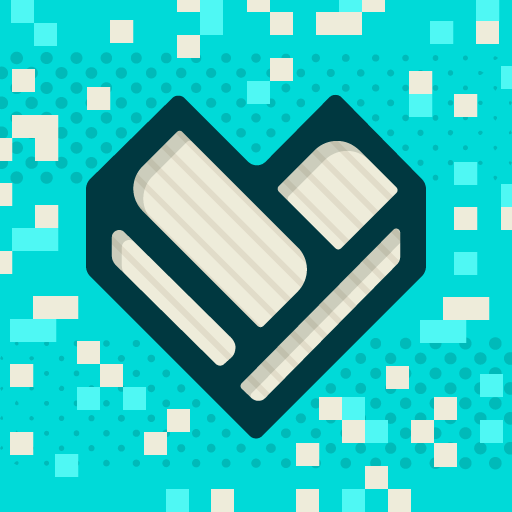
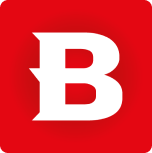

In [160]:
  movie_content=requests.get('https://transcripts.fandom.com/wiki/Finding_Nemo')
  movie = BeautifulSoup(movie_content.text,"html")
  movie

In [161]:
nemo_tokens,nemo_map=get_token_table('https://transcripts.fandom.com/wiki/Finding_Nemo',["dd","p"])
nemo_tokens

pos_tuple  pos token_str  \
Action_number Dialogue_num sent_num token_num                                
1.0           1            0        0             (Wow, NN)   NN       Wow   
              2            0        0              (Mm, NN)   NN        Mm   
              3            0        0             (Wow, NN)   NN       Wow   
              4            0        0          (Mmmhmm, NN)   NN    Mmmhmm   
2.0           5            0        0             (Wow, NN)   NN       Wow   
...                                                     ...  ...       ...   
279.0         1330         0        1            (did, VBD)  VBD       did   
                                    2             (it, PRP)  PRP        it   
              1331         0        0             (Yes, UH)   UH       Yes   
              1332         0        0             (Now, RB)   RB       Now   
                                    1            (what, WP)   WP      what   

                                              term_str  
Action_number Dialogue_num sent_num token_num           
1.0           1            0        0              wow  
              2            0        0               mm  
              3            0        0              wow  
              4            0        0           mmmhmm  
2.0           5            0        0              wow  
...                                                ...  
279.0         1330         0        1              did  
                                    2               it  
              1331         0        0              yes  
              1332         0        0              now  
                                    1             what  

[9885 rows x 4 columns]

In [162]:
nemo_map.character.unique()

array(['MARLIN', 'CORAL', 'NEMO', 'KIDS IN MOUTH', 'LARGE FISH MOM',
       'YOUNG HERMIT CRAB', 'BOB', 'TED', 'PHIL', 'MR. JOHANNSEN',
       'PEARL', 'TAD', 'SHELDON', 'MR. RAY', 'KIDS', 'JIMMY', 'KATHY',
       'MAN', 'DORY', 'BRUCE', 'ANCHOR', 'CHUM', 'BRUCE/ANCHOR/CHUM',
       'ANCHOR/CHUM', 'MARLIN/DORY', 'PELICAN', 'Dr. PHILLIP SHERMAN',
       'BARBARA', 'DR. PHILLIP SHERMAN', 'Dr. Philip Sherman', 'PATIENT',
       'BUBBLES', 'PEACH', 'JACQUES', 'BLOAT', 'DEB', 'GURGLE', 'NIGEL',
       'TANK GANG', 'GILL', 'BLOAT/BUBBLES/GURGLE', 'ALL',
       'GILL We can’t send him off to his death. Darla’s coming in 5 days, so what are we going to do? I’ll tell you what we’re going to do',
       'MOONFISH LEADER', 'MOONFISH', 'Gill', 'Nemo', 'CRUSH', 'SQUIRT',
       'BOTH', 'TURTLE KIDS', 'TURTLE KID 1', 'TURTLE KID 2',
       'TURTLE KID 3', 'TURTLE KID 4', 'TURTLE KID 5', 'TURTLE KID 6',
       'TURTLE KID', 'SMALL FISH', 'BIG FISH', 'LOBSTER', 'SWORDFISH',
       'DOLPHIN', 'FEMALE B

In [163]:
#nemo_tokens=nemo_tokens.reset_index()
#nemo_tokens.character=[re.sub("\sWe[\W\w]+","",text) for text in nemo_tokens["character"]]

In [164]:
#nemo_tokens.character.unique()

In [165]:
nemo_tokens=nemo_tokens.reset_index()
min_dict=nemo_tokens.groupby(['Action_number'])['Dialogue_num'].min().to_dict()
nemo_tokens['Dialogue_num']=[diag_num-min_dict[act_num] for act_num,diag_num in zip(nemo_tokens['Action_number'],nemo_tokens['Dialogue_num'])]

In [166]:
nemo_tokens["movie_id"]='m24'
nemo_tokens=nemo_tokens.set_index(["movie_id","Action_number","Dialogue_num","sent_num"])
nemo_tokens

token_num     pos_tuple  pos  \
movie_id Action_number Dialogue_num sent_num                                 
m24      1.0           0            0                 0     (Wow, NN)   NN   
                       1            0                 0      (Mm, NN)   NN   
                       2            0                 0     (Wow, NN)   NN   
                       3            0                 0  (Mmmhmm, NN)   NN   
         2.0           0            0                 0     (Wow, NN)   NN   
...                                                 ...           ...  ...   
         279.0         10           0                 1    (did, VBD)  VBD   
                                    0                 2     (it, PRP)  PRP   
                       11           0                 0     (Yes, UH)   UH   
                       12           0                 0     (Now, RB)   RB   
                                    0                 1    (what, WP)   WP   

                                             token_str term_str  
movie_id Action_number Dialogue_num sent_num                     
m24      1.0           0            0              Wow      wow  
                       1            0               Mm       mm  
                       2            0              Wow      wow  
                       3            0           Mmmhmm   mmmhmm  
         2.0           0            0              Wow      wow  
...                                                ...      ...  
         279.0         10           0              did      did  
                                    0               it       it  
                       11           0              Yes      yes  
                       12           0              Now      now  
                                    0             what     what  

[9885 rows x 5 columns]

In [167]:
movie_dataframe=movie_dataframe.append(nemo_tokens)

In [168]:
movie_dataframe

token_num     pos_tuple  pos  \
movie_id Action_number Dialogue_num sent_num                                 
m1       1.0           0            0                 0    (Mama, NN)   NN   
                       1            0                 0     (We, PRP)  PRP   
                                    0                 1   (know, VBP)  VBP   
                                    1                 0   (Jyn,, NNP)  NNP   
                                    1                 1  (gather, CC)   CC   
...                                                 ...           ...  ...   
m24      279.0         10           0                 1    (did, VBD)  VBD   
                                    0                 2     (it, PRP)  PRP   
                       11           0                 0     (Yes, UH)   UH   
                       12           0                 0     (Now, RB)   RB   
                                    0                 1    (what, WP)   WP   

                                             token_str term_str  
movie_id Action_number Dialogue_num sent_num                     
m1       1.0           0            0             Mama     mama  
                       1            0               We       we  
                                    0             know     know  
                                    1             Jyn,      jyn  
                                    1           gather   gather  
...                                                ...      ...  
m24      279.0         10           0              did      did  
                                    0               it       it  
                       11           0              Yes      yes  
                       12           0              Now      now  
                                    0             what     what  

[204317 rows x 5 columns]

In [171]:
movie_dataframe.to_csv("./data_out/movie-TOKENS.csv")

In [ ]:
movie_dataframe

## save the scripts as txt files

In [172]:
def html_to_txt(link,title,tag):
    movie_content=requests.get(link)
    movie = BeautifulSoup(movie_content.text,"html")
    script_lines=[line.text for line in movie.find_all(tag)]

    with open(f'./movie_scripts/{title}.txt', 'w', encoding="utf-8") as f:
        for item in script_lines:
            f.write("%s" % item)

In [173]:
movie_list=[
    ["https://transcripts.fandom.com/wiki/Rogue_One:_A_Star_Wars_Story","Rogue_One_A_Star_Wars_Story","p"],
    ["https://transcripts.fandom.com/wiki/Star_Wars_Episode_III:_Revenge_of_the_Sith","Star_Wars_Episode_III_Revenge_of_the_Sith","p"],
    ["https://transcripts.fandom.com/wiki/Star_Wars_Episode_IX:_The_Rise_of_Skywalker","Star_Wars_Episode_IX_The_Rise_of_Skywalker","p"],
    ["https://transcripts.fandom.com/wiki/Captain_America:_The_First_Avenger","Captain_America_The_First_Avenger","dd"],
    ["https://transcripts.fandom.com/wiki/Captain_America:_The_Winter_Soldier","Captain_America_The_Winter_Soldier",["dd","p"]],
    ["https://transcripts.fandom.com/wiki/Captain_America:_Civil_War","Captain_America_Civil_War","dd"],
    ["https://transcripts.fandom.com/wiki/The_Avengers","The_Avengers","p"],
    ["https://transcripts.fandom.com/wiki/Avengers:_Age_of_Ultron","Avengers_Age_of_Ultron","p"],
    ["https://transcripts.fandom.com/wiki/Avengers:_Infinity_War","Avengers_Infinity_War","p"],
    ["https://transcripts.fandom.com/wiki/Avengers:_Endgame","Avengers_Endgame","p"],
    ["https://transcripts.fandom.com/wiki/Captain_Marvel_(2019)","Captain_Marvel","p"],
    ["https://transcripts.fandom.com/wiki/Beauty_and_the_Beast_(1991)","Beauty_and_the_Beast","p"],
    ["https://transcripts.fandom.com/wiki/Inside_Out","Inside_Out",["ul","p"]],
    ["https://transcripts.fandom.com/wiki/Monsters_University","Monsters_University","p"],
    ["https://transcripts.fandom.com/wiki/Monsters,_Inc.","Monsters_Inc","p"],
    ["https://transcripts.fandom.com/wiki/Moana","Moana","dd"],
    ["https://transcripts.fandom.com/wiki/Zootopia","Zootopia","p"],
    ["https://transcripts.fandom.com/wiki/Mulan","Mulan","p"],
    ["https://transcripts.fandom.com/wiki/Soul_(2020)","Soul","li"],
    ['https://transcripts.fandom.com/wiki/Frozen','Frozen',"li"],
    ['https://transcripts.fandom.com/wiki/Frozen_II','Frozen_II',"p"],
    ['https://transcripts.fandom.com/wiki/Tangled','Tangled',"p"],
    ['https://transcripts.fandom.com/wiki/Cars','Cars',["dd",'p']],
    ['https://transcripts.fandom.com/wiki/Finding_Nemo','Nemo',["dd",'p']]   
]


In [ ]:
#for item in movie_list:
#    html_to_txt(item[0],item[1],item[2])